In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!nvidia-cdl

Driver version: 510.85.02
------------------- Device 0 -------------------
Name: NVIDIA GeForce RTX 3090
Memory usage: 18784MiB / 24576MiB
Temperature: 44C
Running processes not found

------------------- Device 1 -------------------
Name: NVIDIA GeForce RTX 3090
Memory usage: 14230MiB / 24576MiB
Temperature: 28C
Running processes not found

------------------- Device 2 -------------------
Name: NVIDIA GeForce RTX 3090
Memory usage:   310MiB / 24576MiB
Temperature: 25C
Running processes not found

------------------- Device 3 -------------------
Name: NVIDIA GeForce RTX 2080 Ti
Memory usage:   247MiB / 11264MiB
Temperature: 30C
Running processes not found

------------------- Device 4 -------------------
Name: NVIDIA GeForce RTX 2080 Ti
Memory usage:   247MiB / 11264MiB
Temperature: 28C
Running processes not found



In [4]:
########## import libraries
import numpy as np
import random
import scipy.stats
import math
import torch
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

from tqdm import tqdm
import pickle
from wikidataintegrator import wdi_core
from wikidata.client import Client
import wikidata
from itertools import compress

import en_core_web_sm
from numpy import trapz
import spacy
import warnings
warnings.filterwarnings("ignore")

########## import functions
from uncertainty import sinlge_model_ue, predict_and_proba, aggregation_plot_sinle_measures
from utils import get_description_name, getScores
from utils import topkSample, greedyPredict, check_t5_sq, first_letter_big, stable_experiments

softmax = nn.Softmax()

########## reproducibility
stable_experiments(42)

########## necessary soft
# spacy.prefer_gpu()
nlp = spacy.load("en_core_web_sm")
#nlp = en_core_web_sm.load()
client = wikidata.client.Client()

########## data for establish relations with words and wikidata ids
##! wget https://dl.fbaipublicfiles.com/GENRE/lang_title2wikidataID-normalized_with_redirect.pkl    


    
########## model
model = AutoModelForSeq2SeqLM.from_pretrained("google/t5-xl-ssm-nq")
tokenizer = AutoTokenizer.from_pretrained("google/t5-xl-ssm-nq")

########## device
#!nvidia-cdl
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
model.to(device)




T5ForConditionalGeneration(
  (shared): Embedding(32128, 2048)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 2048)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=2048, out_features=2048, bias=False)
              (k): Linear(in_features=2048, out_features=2048, bias=False)
              (v): Linear(in_features=2048, out_features=2048, bias=False)
              (o): Linear(in_features=2048, out_features=2048, bias=False)
              (relative_attention_bias): Embedding(32, 32)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=2048, out_features=5120, bias=False)
              (wi_1): Linear(in_features=2048, out_features=5120, bias=False)
       

In [5]:
with open("lang_title2wikidataID-normalized_with_redirect.pkl", "rb") as f:
    lang_title2wikidataID = pickle.load(f)

In [31]:
# useful functions
import scipy.stats
from tqdm import tqdm
from time import time
import json
import collections, functools, operator

softmax = nn.Softmax(dim = -1)

def predict_and_proba(question, model, tokenizer, device, num_beams, max_sequence_length):
    """This function generates sequence = answer on given question
    
    1) it encodes qustion using tokenizer
    2) converts tokenized text to device
    3) generate answer with dredefined beam size using tokenized text
    4) as output we receive answers and their probabilities
    
    """
    
    input_ids = tokenizer([question], return_tensors="pt").input_ids
    input_ids = input_ids.to(device)

    out = model.generate(input_ids,
                         num_return_sequences = num_beams,
                         num_beams = num_beams,
                         eos_token_id = tokenizer.eos_token_id,
                         pad_token_id = tokenizer.pad_token_id,
                         output_scores = True,
                         return_dict_in_generate=True,
                         early_stopping=True,
                         max_length=max_sequence_length)
    
    prediction = [tokenizer.decode(out.sequences[i], skip_special_tokens=True) for i in range(num_beams)]
    prediction = [first_letter_big(word) for word in prediction]
    probs = softmax(out.sequences_scores)
    
    return prediction, probs

def first_letter_big(word):
    try:
        return word[0].upper() + word[1:]
    except:
        return word

def stable_experiments(seed_num):
    
    torch.manual_seed(seed_num)
    random.seed(seed_num)
    np.random.seed(seed_num)

def KL(P,Q):
    """ Epsilon is used here to avoid conditional code for
    checking that neither P nor Q is equal to 0. """
    epsilon = 1e-16

    P = P+epsilon
    #print(P)
    Q = Q+epsilon
    #print(Q)

    kl_divergence = np.sum(P*np.log(P/Q))
    return kl_divergence

def div_d(my_dict, number):

    for i in my_dict:
        my_dict[i] = float(my_dict[i]/number)

    return my_dict 


def get_predictive_distribution(model, tokenizer, question, device, seed = 42,
                                ensemble_size = 5, num_beams = 20, max_sequence_length = 5, need_report = False):
    
    stable_experiments(seed)
    
    # in order to receive MC-dropout results we have to convert model to eval mode
    model.train()
    
    matrix_of_probs = []
    matrix_of_predictions = []

    for i in range(ensemble_size):
        stable_experiments(i)
        prediction, probs = predict_and_proba(question, model,
                                              tokenizer, device,
                                              num_beams, max_sequence_length)
        matrix_of_probs.append(probs)
        matrix_of_predictions.append(prediction)



    matrix_of_probs = torch.stack(matrix_of_probs)
    matrix_of_probs = softmax(matrix_of_probs)
    
    if need_report:
        print("matrix_of_probs", "\n")
        print(matrix_of_probs, "\n")

#         print("matrix_of_predictions", "\n")
#         print(matrix_of_predictions, "\n")

    # !!! below output considers the cituations ensemble_size = 3 and num_beams = 5 
    # (small numbers for brevity of examples of ouputs)

    # output example
    # matrix_of_probs = 
    # tensor([[0.2036, 0.1995, 0.1993, 0.1989, 0.1987],
    #         [0.2767, 0.1873, 0.1828, 0.1769, 0.1764],
    #         [0.2810, 0.1876, 0.1780, 0.1777, 0.1756]], device='cuda:3') 
    
    # output example
    # matrix_of_predictions = 
    # [['A change in', 'A meteorit', 'Tectonic', 'A high sea', 'A focus of'],
    #  ['Earthquakes', 'Geological activity', 'Earthquakes', 'Ge forces', 'Earthquaking'],
    #  ['Earthquakes', 'Earthquaking', 'Earthquake', 'Earthquak', 'Earthquake or']]


    prediction_matrix = np.array([[matrix_of_predictions[j][i] for i in range(num_beams)] for j in range(ensemble_size)])
    
    if need_report:
        print("prediction_matrix", "\n")
        print(prediction_matrix, "\n")

    # output example
    # prediction_matrix = 
    # [['A change in' 'A meteorit' 'Tectonic' 'A high sea' 'A focus of']
    #  ['Earthquakes' 'Geological activity' 'Earthquakes' 'Ge forces'
    #   'Earthquaking']
    #  ['Earthquakes' 'Earthquaking' 'Earthquake' 'Earthquak' 'Earthquake or']] 
    
    return matrix_of_probs, prediction_matrix
    

def UE(model, tokenizer, matrix_of_probs, prediction_matrix, device, question, seed, ensemble_size, num_beams, force_replace_zeros, need_report):
    """
    This function provides estimation of ensemble based (MC-Dropout) Uncertainty metrics:
    - Ensemble Delta
    - Ensemble maxprob
    - Expected Entropy
    - Predictive Entropy
    - Bayesian Active Learning by Disagreement (BALD)
    - Expected pairwise Kullback–Leibler divergence
    - Reversed Mutual Information
    
    """
    
    start = time()
    stable_experiments(seed)
    
    # in order to receive MC-dropout results we have to convert model to eval mode
    model.train()
    



    set_of_index = set(np.hstack(prediction_matrix))
    
    if need_report:
        print("set_of_index", "\n")
        print(set_of_index, "\n")

    # output example 
    # set_of_index = 
    # {'A meteorit', 'Tectonic', 'Earthquaking', 'A focus of', 'A change in', 'A high sea',
    #  'Earthquak', 'Earthquake or', 'Geological activity', 'Earthquake', 'Ge forces', 'Earthquakes'} 


    # initialize matrix of zeros probabilities and fill it with zero probs

    init_mat = np.zeros(shape = (ensemble_size, len(list(set_of_index))))

    # init final matrix
    probs_mat = np.zeros_like(init_mat).tolist()


    # all generated indexes (columns of our final prob matrix)
    possible_indexes = list(set_of_index)


    for raw in range(init_mat.shape[0]):
        for column in range(init_mat.shape[1]):
            probs_mat[raw][column] = {possible_indexes[column]:init_mat[raw, column]}
            
    if need_report:
        print("probs_mat", "\n")
        print(probs_mat, "\n")

    # output example:   
    # probs_mat = 
    # [[{'A meteorit': 0.0}, {'Tectonic': 0.0}, {'Earthquaking': 0.0}, {'A focus of': 0.0}, {'A change in': 0.0},
    #   {'A high sea': 0.0}, {'Earthquak': 0.0}, {'Earthquake or': 0.0}, {'Geological activity': 0.0}, 
    #   {'Earthquake': 0.0}, {'Ge forces': 0.0}, {'Earthquakes': 0.0}], 
    #  [{'A meteorit': 0.0}, {'Tectonic': 0.0}, {'Earthquaking': 0.0}, {'A focus of': 0.0}, {'A change in': 0.0},
    #   {'A high sea': 0.0}, {'Earthquak': 0.0}, {'Earthquake or': 0.0}, {'Geological activity': 0.0},
    #   {'Earthquake': 0.0}, {'Ge forces': 0.0}, {'Earthquakes': 0.0}], 
    #  [{'A meteorit': 0.0}, {'Tectonic': 0.0}, {'Earthquaking': 0.0}, {'A focus of': 0.0}, {'A change in': 0.0},
    #   {'A high sea': 0.0}, {'Earthquak': 0.0}, {'Earthquake or': 0.0}, {'Geological activity': 0.0},
    #   {'Earthquake': 0.0}, {'Ge forces': 0.0}, {'Earthquakes': 0.0}]] 


    # To optimise the process of filling probability matrix let's join dictionaries
    final_matrix_of_probs = []
    for raw in np.array(probs_mat):
        new_dict = {}

        for elem in raw:
            new_dict.update(elem)
        final_matrix_of_probs.append(new_dict)
        
    if need_report:
        print("final_matrix_of_probs", "\n")
        print(final_matrix_of_probs, "\n")

    # output example:   
    # final_matrix_of_probs = 
    # [{'A meteorit': 0.0, 'Tectonic': 0.0, 'Earthquaking': 0.0, 'A focus of': 0.0, 'A change in': 0.0,
    #   'A high sea': 0.0, 'Earthquak': 0.0, 'Earthquake or': 0.0, 'Geological activity': 0.0, 'Earthquake': 0.0,
    #   'Ge forces': 0.0, 'Earthquakes': 0.0}, 
    #  {'A meteorit': 0.0, 'Tectonic': 0.0, 'Earthquaking': 0.0,'A focus of': 0.0, 'A change in': 0.0,
    #   'A high sea': 0.0, 'Earthquak': 0.0, 'Earthquake or': 0.0, 'Geological activity': 0.0, 
    #   'Earthquake': 0.0, 'Ge forces': 0.0, 'Earthquakes': 0.0}, 
    #  {'A meteorit': 0.0, 'Tectonic': 0.0,'Earthquaking': 0.0, 'A focus of': 0.0, 'A change in': 0.0,
    #   'A high sea': 0.0, 'Earthquak': 0.0, 'Earthquake or': 0.0, 'Geological activity': 0.0, 'Earthquake': 0.0, 
    #   'Ge forces': 0.0, 'Earthquakes': 0.0}] 

    for i, prediciton in enumerate(prediction_matrix):
        for j, index in enumerate(prediciton):
            final_matrix_of_probs[i][index] += float(matrix_of_probs[i, j])

    final_matrix_of_probs = np.array(final_matrix_of_probs)
    # examples of output below considers rounding for 3 digits
    
    if need_report:
        print("final_matrix_of_probs", "\n")
        print(final_matrix_of_probs, "\n")

    # output example:   
    # final_matrix_of_probs = 
    # [{'A meteorit': 0.199, 'Tectonic': 0.199, 'Earthquaking': 0.0, 'A focus of': 0.199, 'A change in': 0.204,
    #   'A high sea': 0.199, 'Earthquak': 0.0, 'Earthquake or': 0.0, 'Geological activity': 0.0, 'Earthquake': 0.0, 
    #   'Ge forces': 0.0, 'Earthquakes': 0.0}
    #  {'A meteorit': 0.0, 'Tectonic': 0.0, 'Earthquaking': 0.176, 'A focus of': 0.0, 'A change in': 0.0, 
    #   'A high sea': 0.0, 'Earthquak': 0.0, 'Earthquake or': 0.0, 'Geological activity': 0.187,
    #   'Earthquake': 0.0, 'Ge forces': 0.177, 'Earthquakes': 0.46}
    #  {'A meteorit': 0.0, 'Tectonic': 0.0, 'Earthquaking': 0.188, 'A focus of': 0.0, 'A change in': 0.0,
    #   'A high sea': 0.0, 'Earthquak': 0.178, 'Earthquake or': 0.176, 'Geological activity': 0.0,
    #   'Earthquake': 0.178, 'Ge forces': 0.0, 'Earthquakes': 0.281}] 
    
    
    #######
    
    # corrected final_matrix_of_probs (if probability = 0 we pass keys of final_matrix_of_probs
    # trought decoder by force and replace zero probability)
    
    #########
    
    if force_replace_zeros:

        corrected_final_matrix_of_probs = final_matrix_of_probs.copy()
        input_ids = tokenizer(question, return_tensors="pt").input_ids.to(device)
        changed = False

        for i in range(ensemble_size):
            for key in list(final_matrix_of_probs[i].keys()):
                if final_matrix_of_probs[i][key] == 0.0:

                    # obtain sequence of tokens for predictions (keys in final_matrix_of_probs) where probs = 0.0            
                    labels = tokenizer(key, return_tensors="pt").input_ids.to(device)

                    # we will compute the probability for them by force (since otherwise they just added
                    # to thus pred with 0.0 probability)
                    t = len(input_ids.to("cpu").tolist()[0])
                    cross_entropy_loss = model(input_ids = input_ids, labels = labels).loss.detach().to("cpu")
                    prob = float(2**((-1) * t * cross_entropy_loss))

                    # change zero probs with non-zeros
                    corrected_final_matrix_of_probs[i][key] = prob

                    # normalizing probabilities
                    corrected_probs = torch.stack([torch.tensor(np.array(list(corrected_final_matrix_of_probs[i].values())).reshape(1,-1)) / 
                                                   (torch.tensor(np.array(list(corrected_final_matrix_of_probs[i].values())).reshape(1,-1))).sum(axis = 1)
                                                   for i in range(len(corrected_final_matrix_of_probs))]).reshape(len(corrected_final_matrix_of_probs), -1)
                # it is needed to understand whether we changed something or not
                    changed = True
                else:
                    pass

        # if something is changed
        if changed:
            for i, dict_ in enumerate(corrected_final_matrix_of_probs):
                for j, key in enumerate(list(dict_.keys())):
                    corrected_final_matrix_of_probs[i][key] = float(corrected_probs[i][j])

            # let's replace final_matrix_of_probs by what we achieved
            final_matrix_of_probs = corrected_final_matrix_of_probs
        
        if need_report:
            print("final_matrix_of_probs after change", "\n")
            print(final_matrix_of_probs, "\n")
            
    #########

    # besides uncertainty we need actually a prediction of the ensemble 
    # let's average the probabilities of the corresponding indexes of final_matrix_of_probs
    result = dict(functools.reduce(operator.add,
         map(collections.Counter, list(final_matrix_of_probs))))

    final_ensemble_prediction = div_d(result, len(list(final_matrix_of_probs)))
    
    if need_report:
        print("final_ensemble_prediction", "\n")
        print(final_ensemble_prediction, "\n")
    
    # output example 
    # final_ensemble_prediction = 
    # {'A meteorit': 0.06633333333333334, 'Tectonic': 0.06633333333333334, 'Earthquaking': 0.12133333333333333,
    #  'A focus of': 0.06633333333333334, 'A change in': 0.06799999999999999, 'A high sea': 0.06633333333333334,
    #  'Geological activity': 0.06233333333333333, 'Ge forces': 0.059, 'Earthquakes': 0.24700000000000003, 
    #  'Earthquak': 0.05933333333333333, 'Earthquake or': 0.058666666666666666, 'Earthquake': 0.05933333333333333} 
    

    #### calculation ensemble MC-dropout Uncertainty metrics
    
    # ensemble delta = mean delta over ensemble of models
    deltas = []
    
    for prob_distr in final_matrix_of_probs:

        distribution = list(prob_distr.values())
        deltas.append(
            sorted(distribution)[-1] - sorted(distribution)[-2]
        )

    ensemble_delta = np.mean(deltas)
    
    # ensemble score (ensemble maxprob) = mean maxprob over ensemble of models
    max_probs = []
    
    for prob_distr in final_matrix_of_probs:

        distribution = list(prob_distr.values())
        max_probs.append(
            sorted(distribution)[-1]
        )

    ensemble_max_prob = np.mean(max_probs)
    
    
    #Expected entropy = mean entropy over each ensemble predictive distribution

    entropies = []
    for prob_distr in final_matrix_of_probs:

        distribution = list(prob_distr.values())
        entropies.append(
            scipy.stats.entropy(distribution)
        )
        
    

    eentropy = np.mean(entropies)
    

    # for calculating predictive entropy we have to perate rawise, thus we need a matrix of scores 
    distribution_matrix = np.array([list(x.values()) for x in final_matrix_of_probs])
    
    if need_report:
        print("distribution_matrix", "\n")
        print(distribution_matrix, "\n")
    
    # output example 
    # distribution_matrix =
    # [[0.199 0.199 0.    0.199 0.204 0.199 0.    0.    0.    0.    0.    0.   ]
    #  [0.    0.    0.176 0.    0.    0.    0.    0.    0.187 0.    0.177 0.46 ]
    #  [0.    0.    0.188 0.    0.    0.    0.178 0.176 0.    0.178 0.    0.281]] 
    

    # for Predictive entropy we firstly count mean probability over ensemble predictions for each index
    mean_probs_of_indexes = distribution_matrix.mean(axis = 0)

    # and count entropy over it
    pentropy = scipy.stats.entropy(mean_probs_of_indexes)
    

    # Bayesian Active Learning by Disagreement (BALD) = Predictive entropy - Expected entropy
    bald = pentropy - eentropy

    # Expected pairwise Kullback–Leibler divergence
    # for it we need indexes of every pair of elements without repetition and coincidence N*(N-1)/2
    res = [list(dict.fromkeys([(i, min(j+i+1, (ensemble_size-1))) for j in range(ensemble_size)])) for i in range(ensemble_size)][:-1]
    indexes_that_we_want = [item for sublist in res for item in sublist]

    # when we have indexes that we want we can calculate mean KL divergence over each pair
    epkl = np.mean([KL(distribution_matrix[x[0]], distribution_matrix[x[1]]) for x in indexes_that_we_want])

    # Reversed Mutual Information = Expected pairwise Kullback–Leibler divergence - BALD
    rmi = epkl - bald

    end = time()

    if need_report:
        print("Duration of calculation = ", np.round(end - start, 4), "sec.")
        print("MC-Dropout Ensemble based Uncertainty measures:")
        print("Ensemble Delta = ", np.round(ensemble_delta, 4))
        print("Ensemble Score (Max prob) = ", np.round(ensemble_max_prob, 4))
        print("Expected Entropy = ", np.round(eentropy, 4))
        print("Predictive Entropy = ", np.round(pentropy,4))
        print("BALD = ", np.round(bald,4))
        print("EPKL = ", np.round(epkl,4))
        print("RMI = ", np.round(rmi,4))
        
    return ensemble_delta, ensemble_max_prob, eentropy, pentropy, bald, epkl, rmi, final_ensemble_prediction


def area_under_rejection_curve(data, name, topk, num_quantiles, number_of_digids_round = 4):
    """
    This function calculates absolute Area under Rejection curve to 
    estimate overall quality of uncertainty estimation
    """
    max_area = (100 - 100 / num_quantiles) * 100

    x = (100.0 - np.array(list(data[f"{name}"][topk].keys())).astype(float))[::-1]
    y = np.array(list(data[f"{name}"][topk].values())).astype(float)[::-1]
    area = np.round(trapz(y = y, x = x, dx=1) / max_area, number_of_digids_round)

    return area

softmax = nn.Softmax()
def from_text_to_id(x):
    try:
        return list(lang_title2wikidataID[("en", x)])[0]
    except:
        return "None"
    
    
def UE_ensemble(
    ensemble_metric_name: "str",
    answers: "list",
    dataset_name: "str",
    predictions,
    num_quantiles,
    number_of_questions, 
    plot_rejection_curves = True,
    ensemble_deltas = None,
    ensemble_max_probs = None,
    eentropies = None,
    pentropies = None,
    balds = None,
    epkls = None,
    rmis = None,
    top_ks = [1, 2, 5, 10, 20],
    model_type = "T5_XL_SSM_NQ_model",
    need_report = False):
    
    """
    possible ensemble metric names:
        
        "ensemble delta",
        "ensemble maxprob",
        "expected entropy",
        "predictive entropy",
        "BALD", 
        "EPKL",
        "RMI"
        
        
    """
    if (ensemble_metric_name == "ensemble delta") or (ensemble_metric_name == "ensemble maxprob"):
        quants = [thresh / num_quantiles for thresh in range(0, num_quantiles)]
    else:    
        quants = [thresh / num_quantiles for thresh in range(1, num_quantiles+1)]
        
    
    
    if  ensemble_metric_name == "ensemble delta":
        ue_metrics = ensemble_deltas
            
    if  ensemble_metric_name == "ensemble maxprob":
        ue_metrics = ensemble_max_probs
        
    if  ensemble_metric_name == "expected entropy":
        ue_metrics = eentropies
        
    if  ensemble_metric_name == "predictive entropy":
        ue_metrics = pentropies
        
    if  ensemble_metric_name == "BALD":
        ue_metrics = balds
        
    if  ensemble_metric_name == "EPKL":
        ue_metrics = epkls
    
    if  ensemble_metric_name == "RMI":
        ue_metrics = rmis
        
    
    thresholds_ue_metric = [np.quantile(ue_metrics, q) for q in quants]

    if (ensemble_metric_name == "ensemble delta") or (ensemble_metric_name == "ensemble maxprob"):
        thresholds_ue_metric = thresholds_ue_metric[::-1]

    accuracy_for_each_topk_ue_metrics = {}

    #top_k pred
    for top_k in top_ks:

        accuracy_for_each_quantile = {}

        for quantile in range(num_quantiles):
            
            if ensemble_metric_name in ["expected entropy", "predictive entropy", "BALD", "EPKL", "RMI"]:
                # list of predictions
                list_of_predictions = list(compress(predictions, ue_metrics <= thresholds_ue_metric[quantile]))
                if need_report:
                    print("list_of_predictions", list_of_predictions, "\n")

                #list of correct answers
                list_of_correct_answers = list(compress(answers[:number_of_questions], ue_metrics <= thresholds_ue_metric[quantile]))
                if need_report:
                    print("list_of_correct_answers", list_of_correct_answers, "\n")
                
            elif ensemble_metric_name in ["ensemble delta", "ensemble maxprob"]:
                
                # list of predictions
                list_of_predictions = list(compress(predictions, ue_metrics >= thresholds_ue_metric[quantile]))
                if need_report:
                    print("len(list_of_predictions)", len(list_of_predictions), "\n")

                #list of correct answers
                list_of_correct_answers = list(compress(answers[:number_of_questions], ue_metrics >= thresholds_ue_metric[quantile]))
                
            
            
            # choose top k predictions
            top_k_list_of_predictions = [i[:top_k] for i in list_of_predictions]
            if need_report:
                print("top_k_list_of_predictions", top_k_list_of_predictions, "\n")


            top_k_list_of_predicted_ids= []
            for sample in top_k_list_of_predictions:
                new = []
                for prediction in sample:
                    try:
                        x = from_text_to_id(prediction)
                    except:
                        x = "None"
                    new.append(x)

                top_k_list_of_predicted_ids.append(new)
            
            if need_report:
                print("top_k_list_of_predicted_ids", top_k_list_of_predicted_ids)
            

            right = 0
            for i in range(len(list_of_correct_answers)):
                if any(item in top_k_list_of_predicted_ids[i] for item in list_of_correct_answers[i]):
                    right += 1
                else:
                    pass

            accuracy = np.round(right/len(list_of_correct_answers), 4)*100
            
            if need_report:
                print("accuracy", accuracy, "\n")
                print(f"Top-{top_k} accuracy on the {(quantile+1)*(int(100/num_quantiles))}% the most confident from the entropy point of view = {accuracy}%", "\n")

            accuracy_for_each_quantile[(quantile+1)*(int(100/num_quantiles))] = accuracy
        accuracy_for_each_topk_ue_metrics[top_k] = accuracy_for_each_quantile
            
            
            
            
        if need_report:
            print("\n", "\n", "\n")
    
    if need_report:
        print("accuracy_for_each_topk_ue_metrics", accuracy_for_each_topk_ue_metrics, "\n")
        
    
    if plot_rejection_curves:
        
        font = {'family': 'serif',
            'color': 'darkred',
            'weight': 'normal',
            'size': 16
            }

        font_title = {'family': 'serif',
                      'color': 'darkred',
                      'weight': 'normal',
                      'size': 20
                      }


        plt.figure(figsize = (15, 9))
        plt.title(f"Rejection curves based on {ensemble_metric_name} for {dataset_name}", fontdict=font_title)

        plt.xlabel("Rejection rate, %", fontdict=font)
        plt.ylabel("Accuracy, %", fontdict=font)
        plt.xticks(ticks=np.arange(0, 100, step=5))
        plt.grid(color='black', linewidth=0.15)

        
        if 1 in top_ks:
            plt.plot(100 - np.array(list(accuracy_for_each_topk_ue_metrics[1].keys())),
                     np.array(list(accuracy_for_each_topk_ue_metrics[1].values())),
                     label=f"Top-{1} Accuracy via {ensemble_metric_name}", c="blue", marker='.', markersize=13, linewidth=0.8);
            
        if 2 in top_ks:
            plt.plot(100 - np.array(list(accuracy_for_each_topk_ue_metrics[2].keys())),
                     np.array(list(accuracy_for_each_topk_ue_metrics[2].values())),
                     label=f"Top-{2} Accuracy via {ensemble_metric_name}", c="red", marker='.', markersize=13, linewidth=0.8);
        
        if 5 in top_ks:
            plt.plot(100 - np.array(list(accuracy_for_each_topk_ue_metrics[5].keys())),
                     np.array(list(accuracy_for_each_topk_ue_metrics[5].values())),
                     label=f"Top-{5} Accuracy via {ensemble_metric_name}", c="green", marker='.', markersize=13, linewidth=0.8);
        
        if 10 in top_ks:
            plt.plot(100 - np.array(list(accuracy_for_each_topk_ue_metrics[10].keys())),
                     np.array(list(accuracy_for_each_topk_ue_metrics[10].values())),
                     label=f"Top-{10} Accuracy via {ensemble_metric_name}", c="orange", marker='.', markersize=13, linewidth=0.8);
        
        if 20 in top_ks:
            plt.plot(100 - np.array(list(accuracy_for_each_topk_ue_metrics[20].keys())),
                     np.array(list(accuracy_for_each_topk_ue_metrics[20].values())),
                     label=f"Top-{20} Accuracy via {ensemble_metric_name}", c="pink", marker='.', markersize=13, linewidth=0.8);

        if 1 in top_ks:
            accuracy_on_full_data_top_1 = np.array(list(accuracy_for_each_topk_ue_metrics[1].values()))[-1]
        if 2 in top_ks:
            accuracy_on_full_data_top_2 = np.array(list(accuracy_for_each_topk_ue_metrics[2].values()))[-1]
        if 5 in top_ks:
            accuracy_on_full_data_top_5 = np.array(list(accuracy_for_each_topk_ue_metrics[5].values()))[-1]
        if 10 in top_ks:
            accuracy_on_full_data_top_10 = np.array(list(accuracy_for_each_topk_ue_metrics[10].values()))[-1]
        if 20 in top_ks:
            accuracy_on_full_data_top_20 = np.array(list(accuracy_for_each_topk_ue_metrics[20].values()))[-1]

        if 1 in top_ks:
            plt.annotate("{}".format(np.round(accuracy_on_full_data_top_1, 2)), (0 - 4.5, accuracy_on_full_data_top_1));
        if 2 in top_ks:
            plt.annotate("{}".format(np.round(accuracy_on_full_data_top_2, 2)), (0 - 4.5, accuracy_on_full_data_top_2));
        if 5 in top_ks:
            plt.annotate("{}".format(np.round(accuracy_on_full_data_top_5, 2)), (0 - 4.5, accuracy_on_full_data_top_5));
        if 10 in top_ks:
            plt.annotate("{}".format(np.round(accuracy_on_full_data_top_10, 2)), (0 - 4.5, accuracy_on_full_data_top_10));
        if 20 in top_ks:
            plt.annotate("{}".format(np.round(accuracy_on_full_data_top_20, 2)), (0 - 4.5, accuracy_on_full_data_top_20));

        plt.legend(fontsize=16);
        plt.show()

        plt.savefig(f"QA_Rejection_curves_based_on_{ensemble_metric_name}_for_{dataset_name}_{model_type}_model.png", dpi = 300)

    
    return accuracy_for_each_topk_ue_metrics, ue_metrics




    
def obtain_probs_predicts_and_metrics_from_begin(
    data: "list of questions",
    data_name,
    number_of_questions,
    model,
    tokenizer,
    device,
    seed,
    ensemble_size,
    num_beams,
    max_sequence_length,
    force_replace_zeros,
    need_report
):

    ensemble_deltas, ensemble_max_probs, eentropies, pentropies, balds, epkls, rmis, predictions = [], [], [], [], [], [], [], []
    matrixes_of_probs, matrixes_of_predictions, predictions_matrix = [], [], []

    # for the case when we do not have prodictive distriution -> we have to compute it and after it estimate uncertainty

    for question_index, question in enumerate(tqdm(data[:number_of_questions])):

        matrix_of_probs, prediction_matrix = get_predictive_distribution(model = model,
                                                                         tokenizer = tokenizer,
                                                                         question = question,
                                                                         device = device,
                                                                         seed = seed,
                                                                         ensemble_size = ensemble_size,
                                                                         num_beams = num_beams,
                                                                         max_sequence_length = max_sequence_length,
                                                                         need_report = need_report)
        matrix_of_probs = matrix_of_probs.to("cpu")
        matrixes_of_probs.append(matrix_of_probs)
        predictions_matrix.append(prediction_matrix)


        ensemble_delta, ensemble_max_prob, eentropy, pentropy, bald, epkl, rmi, final_ensemble_prediction = UE(model = model,
                                                                                                               tokenizer = tokenizer,
                                                                                                               device=device,
                                                                                                               matrix_of_probs = matrixes_of_probs[question_index],
                                                                                                               prediction_matrix = predictions_matrix[question_index],
                                                                                                               question = question,
                                                                                                               seed = seed,
                                                                                                               ensemble_size = ensemble_size,
                                                                                                               num_beams = num_beams,
                                                                                                               force_replace_zeros=force_replace_zeros,
                                                                                                               need_report = need_report)
        predictions.append(final_ensemble_prediction)
        ensemble_deltas.append(ensemble_delta)
        ensemble_max_probs.append(ensemble_max_prob)
        eentropies.append(eentropy)
        pentropies.append(pentropy)
        balds.append(bald)
        epkls.append(epkl)
        rmis.append(rmi)


    # sort predictions by highest probability
    preds = [sorted(predictions[i].items(), key=lambda x: x[1], reverse=True) for i in range(len(predictions))]


    res = []
    for i in preds:
        res.append([j[0] for j in i])

    final_dictionary = {"matrixes_of_probs":matrixes_of_probs,
                        "predictions_matrix":predictions_matrix,
                        "predictions":predictions,
                        "preds":preds,
                        "res":res,
                        "ensemble_deltas":ensemble_deltas,
                        "ensemble_max_probs":ensemble_max_probs,
                        "eentropies":eentropies, 
                        "pentropies":pentropies,
                        "balds":balds, 
                        "epkls":epkls, 
                        "rmis":rmis,
                        "data_name":data_name,
                        "num_beams":num_beams,
                        "ensemble_size":ensemble_size}
    
    return final_dictionary



def obtain_probs_predicts_and_metrics_from_matrixes(
    matrixes_of_probs,
    predictions_matrix,
    number_of_questions,
    data_name,
    seed,
    model,
    tokenizer,
    ensemble_size,
    num_beams,
    device,
    force_replace_zeros,
    need_report
):

    # for the case when we have predictive distribution: predictions with probabilities

    for question_index in tqdm(range(number_of_questions)):


        ensemble_delta, ensemble_max_prob, eentropy, pentropy, bald, epkl, rmi, final_ensemble_prediction = UE(model = model,
                                                                                                               tokenizer = tokenizer,
                                                                                                               device=device,
                                                                                                               matrix_of_probs = matrixes_of_probs[question_index],
                                                                                                               prediction_matrix = predictions_matrix[question_index],
                                                                                                               question = question,
                                                                                                               seed = seed,
                                                                                                               ensemble_size = ensemble_size,
                                                                                                               num_beams = num_beams,
                                                                                                               force_replace_zeros=force_replace_zeros,
                                                                                                               need_report = need_report)
        predictions.append(final_ensemble_prediction)
        ensemble_deltas.append(ensemble_delta)
        ensemble_max_probs.append(ensemble_max_prob)
        eentropies.append(eentropy)
        pentropies.append(pentropy)
        balds.append(bald)
        epkls.append(epkl)
        rmis.append(rmi)


    # sort predictions by highest probability
    preds = [sorted(predictions[i].items(), key=lambda x: x[1], reverse=True) for i in range(len(predictions))]

    res = []
    for i in preds:
        res.append([j[0] for j in i])




    final_dictionary = {"matrixes_of_probs":matrixes_of_probs,
                        "predictions_matrix":predictions_matrix,
                        "predictions":predictions,
                        "preds":preds,
                        "res":res,
                        "ensemble_deltas":ensemble_deltas,
                        "ensemble_max_probs":ensemble_max_probs,
                        "eentropies":eentropies, 
                        "pentropies":pentropies,
                        "balds":balds, 
                        "epkls":epkls, 
                        "rmis":rmis,
                        "data_name":data_name}
    
    return final_dictionary


def get_rubq_question_entities(uris):
    """Extracts gt entities from RuBQ WD uris"""
    ents = []
    if type(uris) == list:
        for uri in uris:
            ents.append(uri.split("/")[-1])
    else:
        ents = [None]

    return ents

    
    
def aggregation_plot_ensemble_measures(
    ue_metrics_to_plot: "list",
    top_k_to_plot: "list",
    name_of_dataset,
    accuracy_for_each_topk_ensemble_maxprob = None,
    accuracy_for_each_topk_ensemble_delta = None,
    accuracy_for_each_topk_eentropy = None,
    accuracy_for_each_topk_pentropy = None,
    accuracy_for_each_topk_bald = None,
    accuracy_for_each_topk_epkl = None,
    accuracy_for_each_topk_rmi = None,
    model_name = "T5_XL_SSM_NQ"
):
    font = {'family': 'serif',
            'color': 'darkred',
            'weight': 'normal',
            'size': 20
            }

    font_title = {'family': 'serif',
                  'color': 'darkred',
                  'weight': 'normal',
                  'size': 24
                  }

    plt.figure(figsize = (24, 20))
    plt.title(f"Rejection curves based on Single model UE measures for {name_of_dataset}", fontdict=font_title)
    plt.xlabel("Rejection rate, %", fontdict=font)
    plt.ylabel("Accuracy, %", fontdict=font)
    plt.xticks(ticks=np.arange(0, 100, step=5), size = 14)
    plt.yticks(size = 14)
    plt.grid(color='black', linewidth=0.15)

    linewidth = 1.8
    markersize = 9
    
    if 1 in top_k_to_plot:
        
        if "expected entropy" in ue_metrics_to_plot:

            plt.plot(100 - np.array(list(accuracy_for_each_topk_eentropy[1].keys())),
                     np.array(list(accuracy_for_each_topk_eentropy[1].values())),
                     label=f"Top-{1} Accuracy via Expected Entropy", c="blue", marker='d', markersize=markersize, linewidth=1.5);

        if "predictive entropy" in ue_metrics_to_plot:
            
            plt.plot(100 - np.array(list(accuracy_for_each_topk_pentropy[1].keys())),
                     np.array(list(accuracy_for_each_topk_pentropy[1].values())),
                     label=f"Top-{1} Accuracy via Predictive Entropy", c="blue", marker='.', markersize=markersize, linewidth=linewidth, linestyle = '--');
        
        if "BALD" in ue_metrics_to_plot:
            
            plt.plot(100 - np.array(list(accuracy_for_each_topk_bald[1].keys())),
                 np.array(list(accuracy_for_each_topk_bald[1].values())),
                 label=f"Top-{1} Accuracy via BALD", c="blue", marker='*', markersize=markersize, linewidth=linewidth, linestyle = ':');
            
        if "EPKL" in ue_metrics_to_plot:

            plt.plot(100 - np.array(list(accuracy_for_each_topk_epkl[1].keys())),
                     np.array(list(accuracy_for_each_topk_epkl[1].values())),
                     label=f"Top-{1} Accuracy via EPKL", c="blue", marker='d', markersize=markersize, linewidth=1.5);

        if "RMI" in ue_metrics_to_plot:
            
            plt.plot(100 - np.array(list(accuracy_for_each_topk_rmi[1].keys())),
                     np.array(list(accuracy_for_each_topk_rmi[1].values())),
                     label=f"Top-{1} Accuracy via RMI", c="blue", marker='*', markersize=markersize, linewidth=linewidth, linestyle = '--');
        
        if "ensemble delta" in ue_metrics_to_plot:
            
            plt.plot(100 - np.array(list(accuracy_for_each_topk_ensemble_delta[1].keys())),
                 np.array(list(accuracy_for_each_topk_ensemble_delta[1].values())),
                 label=f"Top-{1} Accuracy via ensemble delta", c="blue", marker='<', markersize=markersize, linewidth=linewidth, linestyle = '-');
            
        if "ensemble maxprob" in ue_metrics_to_plot:
            
            plt.plot(100 - np.array(list(accuracy_for_each_topk_ensemble_maxprob[1].keys())),
                 np.array(list(accuracy_for_each_topk_ensemble_maxprob[1].values())),
                 label=f"Top-{1} Accuracy via ensemble maxprob", c="blue", marker='<', markersize=markersize, linewidth=linewidth, linestyle = ':');



    if 2 in top_k_to_plot:
        
        if "expected entropy" in ue_metrics_to_plot:

            plt.plot(100 - np.array(list(accuracy_for_each_topk_eentropy[2].keys())),
                     np.array(list(accuracy_for_each_topk_eentropy[2].values())),
                     label=f"Top-{2} Accuracy via Expected Entropy", c="red", marker='d', markersize=markersize, linewidth=1.5);

        if "predictive entropy" in ue_metrics_to_plot:
            
            plt.plot(100 - np.array(list(accuracy_for_each_topk_pentropy[2].keys())),
                     np.array(list(accuracy_for_each_topk_pentropy[2].values())),
                     label=f"Top-{2} Accuracy via Predictive Entropy", c="red", marker='.', markersize=markersize, linewidth=linewidth, linestyle = '--');
        
        if "BALD" in ue_metrics_to_plot:
            
            plt.plot(100 - np.array(list(accuracy_for_each_topk_bald[2].keys())),
                 np.array(list(accuracy_for_each_topk_bald[2].values())),
                 label=f"Top-{2} Accuracy via BALD", c="red", marker='*', markersize=markersize, linewidth=linewidth, linestyle = ':');
            
        if "EPKL" in ue_metrics_to_plot:

            plt.plot(100 - np.array(list(accuracy_for_each_topk_epkl[2].keys())),
                     np.array(list(accuracy_for_each_topk_epkl[2].values())),
                     label=f"Top-{2} Accuracy via EPKL", c="red", marker='d', markersize=markersize, linewidth=1.5);

        if "RMI" in ue_metrics_to_plot:
            
            plt.plot(100 - np.array(list(accuracy_for_each_topk_rmi[2].keys())),
                     np.array(list(accuracy_for_each_topk_rmi[2].values())),
                     label=f"Top-{2} Accuracy via RMI", c="red", marker='*', markersize=markersize, linewidth=linewidth, linestyle = '--');
        
        if "ensemble delta" in ue_metrics_to_plot:
            
            plt.plot(100 - np.array(list(accuracy_for_each_topk_ensemble_delta[2].keys())),
                 np.array(list(accuracy_for_each_topk_ensemble_delta[2].values())),
                 label=f"Top-{2} Accuracy via ensemble delta", c="red", marker='<', markersize=markersize, linewidth=linewidth, linestyle = '-');
        
        if "ensemble maxprob" in ue_metrics_to_plot:
            
            plt.plot(100 - np.array(list(accuracy_for_each_topk_ensemble_maxprob[2].keys())),
                 np.array(list(accuracy_for_each_topk_ensemble_maxprob[2].values())),
                 label=f"Top-{2} Accuracy via ensemble maxprob", c="red", marker='<', markersize=markersize, linewidth=linewidth, linestyle = ':');


    
    if 5 in top_k_to_plot:
        
        if "expected entropy" in ue_metrics_to_plot:

            plt.plot(100 - np.array(list(accuracy_for_each_topk_eentropy[5].keys())),
                     np.array(list(accuracy_for_each_topk_eentropy[5].values())),
                     label=f"Top-{5} Accuracy via Expected Entropy", c="green", marker='d', markersize=markersize, linewidth=1.5);

        if "predictive entropy" in ue_metrics_to_plot:
            
            plt.plot(100 - np.array(list(accuracy_for_each_topk_pentropy[5].keys())),
                     np.array(list(accuracy_for_each_topk_pentropy[5].values())),
                     label=f"Top-{5} Accuracy via Predictive Entropy", c="green", marker='.', markersize=markersize, linewidth=linewidth, linestyle = '--');
        
        if "BALD" in ue_metrics_to_plot:
            
            plt.plot(100 - np.array(list(accuracy_for_each_topk_bald[5].keys())),
                 np.array(list(accuracy_for_each_topk_bald[5].values())),
                 label=f"Top-{5} Accuracy via BALD", c="green", marker='*', markersize=markersize, linewidth=linewidth, linestyle = ':');
            
        if "EPKL" in ue_metrics_to_plot:

            plt.plot(100 - np.array(list(accuracy_for_each_topk_epkl[5].keys())),
                     np.array(list(accuracy_for_each_topk_epkl[5].values())),
                     label=f"Top-{5} Accuracy via EPKL", c="green", marker='d', markersize=markersize, linewidth=1.5);

        if "RMI" in ue_metrics_to_plot:
            
            plt.plot(100 - np.array(list(accuracy_for_each_topk_rmi[5].keys())),
                     np.array(list(accuracy_for_each_topk_rmi[5].values())),
                     label=f"Top-{5} Accuracy via RMI", c="green", marker='*', markersize=markersize, linewidth=linewidth, linestyle = '--');
        
        if "ensemble delta" in ue_metrics_to_plot:
            
            plt.plot(100 - np.array(list(accuracy_for_each_topk_ensemble_delta[5].keys())),
                 np.array(list(accuracy_for_each_topk_ensemble_delta[5].values())),
                 label=f"Top-{5} Accuracy via ensemble delta", c="green", marker='<', markersize=markersize, linewidth=linewidth, linestyle = '-');

        if "ensemble maxprob" in ue_metrics_to_plot:
            
            plt.plot(100 - np.array(list(accuracy_for_each_topk_ensemble_maxprob[5].keys())),
                 np.array(list(accuracy_for_each_topk_ensemble_maxprob[5].values())),
                 label=f"Top-{5} Accuracy via ensemble maxprob", c="green", marker='<', markersize=markersize, linewidth=linewidth, linestyle = ':');

        
    if 10 in top_k_to_plot:
        
        if "expected entropy" in ue_metrics_to_plot:

            plt.plot(100 - np.array(list(accuracy_for_each_topk_eentropy[10].keys())),
                     np.array(list(accuracy_for_each_topk_eentropy[10].values())),
                     label=f"Top-{10} Accuracy via Expected Entropy", c="orange", marker='d', markersize=markersize, linewidth=1.5);

        if "predictive entropy" in ue_metrics_to_plot:
            
            plt.plot(100 - np.array(list(accuracy_for_each_topk_pentropy[10].keys())),
                     np.array(list(accuracy_for_each_topk_pentropy[10].values())),
                     label=f"Top-{10} Accuracy via Predictive Entropy", c="orange", marker='.', markersize=markersize, linewidth=linewidth, linestyle = '--');
        
        if "BALD" in ue_metrics_to_plot:
            
            plt.plot(100 - np.array(list(accuracy_for_each_topk_bald[10].keys())),
                 np.array(list(accuracy_for_each_topk_bald[10].values())),
                 label=f"Top-{10} Accuracy via BALD", c="orange", marker='*', markersize=markersize, linewidth=linewidth, linestyle = ':');
            
        if "EPKL" in ue_metrics_to_plot:

            plt.plot(100 - np.array(list(accuracy_for_each_topk_epkl[10].keys())),
                     np.array(list(accuracy_for_each_topk_epkl[10].values())),
                     label=f"Top-{10} Accuracy via EPKL", c="orange", marker='d', markersize=markersize, linewidth=1.5);

        if "RMI" in ue_metrics_to_plot:
            
            plt.plot(100 - np.array(list(accuracy_for_each_topk_rmi[10].keys())),
                     np.array(list(accuracy_for_each_topk_rmi[10].values())),
                     label=f"Top-{10} Accuracy via RMI", c="orange", marker='*', markersize=markersize, linewidth=linewidth, linestyle = '--');
        
        if "ensemble delta" in ue_metrics_to_plot:
            
            plt.plot(100 - np.array(list(accuracy_for_each_topk_ensemble_delta[10].keys())),
                 np.array(list(accuracy_for_each_topk_ensemble_delta[10].values())),
                 label=f"Top-{10} Accuracy via ensemble delta", c="orange", marker='<', markersize=markersize, linewidth=linewidth, linestyle = '-');
        
        if "ensemble maxprob" in ue_metrics_to_plot:
            
            plt.plot(100 - np.array(list(accuracy_for_each_topk_ensemble_maxprob[10].keys())),
                 np.array(list(accuracy_for_each_topk_ensemble_maxprob[10].values())),
                 label=f"Top-{10} Accuracy via ensemble maxprob", c="orange", marker='<', markersize=markersize, linewidth=linewidth, linestyle = ':');

        
    if 20 in top_k_to_plot:
        
        if "expected entropy" in ue_metrics_to_plot:

            plt.plot(100 - np.array(list(accuracy_for_each_topk_eentropy[20].keys())),
                     np.array(list(accuracy_for_each_topk_eentropy[20].values())),
                     label=f"Top-{20} Accuracy via Expected Entropy", c="pink", marker='d', markersize=markersize, linewidth=1.5);

        if "predictive entropy" in ue_metrics_to_plot:
            
            plt.plot(100 - np.array(list(accuracy_for_each_topk_pentropy[20].keys())),
                     np.array(list(accuracy_for_each_topk_pentropy[20].values())),
                     label=f"Top-{20} Accuracy via Predictive Entropy", c="pink", marker='.', markersize=markersize, linewidth=linewidth, linestyle = '--');
        
        if "BALD" in ue_metrics_to_plot:
            
            plt.plot(100 - np.array(list(accuracy_for_each_topk_bald[20].keys())),
                 np.array(list(accuracy_for_each_topk_bald[20].values())),
                 label=f"Top-{20} Accuracy via BALD", c="pink", marker='*', markersize=markersize, linewidth=linewidth, linestyle = ':');
            
        if "EPKL" in ue_metrics_to_plot:

            plt.plot(100 - np.array(list(accuracy_for_each_topk_epkl[20].keys())),
                     np.array(list(accuracy_for_each_topk_epkl[20].values())),
                     label=f"Top-{20} Accuracy via EPKL", c="pink", marker='d', markersize=markersize, linewidth=1.5);

        if "RMI" in ue_metrics_to_plot:
            
            plt.plot(100 - np.array(list(accuracy_for_each_topk_rmi[20].keys())),
                     np.array(list(accuracy_for_each_topk_rmi[20].values())),
                     label=f"Top-{20} Accuracy via RMI", c="pink", marker='*', markersize=markersize, linewidth=linewidth, linestyle = '--');
        
        if "ensemble delta" in ue_metrics_to_plot:
            
            plt.plot(100 - np.array(list(accuracy_for_each_topk_ensemble_delta[20].keys())),
                 np.array(list(accuracy_for_each_topk_ensemble_delta[20].values())),
                 label=f"Top-{20} Accuracy via ensemble delta", c="pink", marker='<', markersize=markersize, linewidth=linewidth, linestyle = '-');
    
    
        if "ensemble maxprob" in ue_metrics_to_plot:
            
            plt.plot(100 - np.array(list(accuracy_for_each_topk_ensemble_maxprob[20].keys())),
                 np.array(list(accuracy_for_each_topk_ensemble_maxprob[20].values())),
                 label=f"Top-{20} Accuracy via ensemble maxprob", c="pink", marker='<', markersize=markersize, linewidth=linewidth, linestyle = ':');

        
    if accuracy_for_each_topk_ensemble_maxprob is not None:
        data_acc = accuracy_for_each_topk_ensemble_maxprob
    
    if accuracy_for_each_topk_ensemble_delta is not None:
        data_acc = accuracy_for_each_topk_ensemble_delta
        
    if accuracy_for_each_topk_rmi is not None:
        data_acc = accuracy_for_each_topk_rmi
        
    if accuracy_for_each_topk_epkl is not None:
        data_acc = accuracy_for_each_topk_epkl
        
    if accuracy_for_each_topk_bald is not None:
        data_acc = accuracy_for_each_topk_bald
        
    if accuracy_for_each_topk_eentropy is not None:
        data_acc = accuracy_for_each_topk_eentropy
        
    if accuracy_for_each_topk_pentropy is not None:
        data_acc = accuracy_for_each_topk_pentropy
        



    if 1 in top_k_to_plot:
        accuracy_on_full_data_top_1 = np.array(list(data_acc[1].values()))[-1]
    if 2 in top_k_to_plot:
        accuracy_on_full_data_top_2 = np.array(list(data_acc[2].values()))[-1]
    if 5 in top_k_to_plot:
        accuracy_on_full_data_top_5 = np.array(list(data_acc[5].values()))[-1]
    if 10 in top_k_to_plot:
        accuracy_on_full_data_top_10 = np.array(list(data_acc[10].values()))[-1]
    if 20 in top_k_to_plot:
        accuracy_on_full_data_top_20 = np.array(list(data_acc[20].values()))[-1]
    
    if 1 in top_k_to_plot:
        plt.annotate("{}".format(np.round(accuracy_on_full_data_top_1, 2)), (0 - 4.5, accuracy_on_full_data_top_1), size = 14);
    if 2 in top_k_to_plot:
        plt.annotate("{}".format(np.round(accuracy_on_full_data_top_2, 2)), (0 - 4.5, accuracy_on_full_data_top_2), size = 14);
    if 5 in top_k_to_plot:
        plt.annotate("{}".format(np.round(accuracy_on_full_data_top_5, 2)), (0 - 4.5, accuracy_on_full_data_top_5), size = 14);
    if 10 in top_k_to_plot:
        plt.annotate("{}".format(np.round(accuracy_on_full_data_top_10, 2)), (0 - 4.5, accuracy_on_full_data_top_10), size = 14);
    if 20 in top_k_to_plot:
        plt.annotate("{}".format(np.round(accuracy_on_full_data_top_20, 2)), (0 - 4.5, accuracy_on_full_data_top_20), size = 14);

    plt.legend(fontsize=14, loc = 2);

    plt.savefig(f"QA_Rejection_curves_based_on_single_model_UE_mes_for_{name_of_dataset}_{model_name}_model.png", dpi = 300)


def total_experiment_uncertainty_mc_dropout(

    data : "list",
    answers : "list",
    data_name : "str",
    model,
    tokenizer,
    dropout_rate = 0.1,
    output_file_name = "SQ_In_GRAPH_MC_DROPOUT_BS10",
    model_type = "T5_XL_SSM_NQ_model",
    num_quantiles = 20,
    seed = 42,
    ensemble_size = 5,
    num_beams = 10,
    need_report = False,
    plot_rejection_curves = True,
    top_ks = [1, 2, 5, 10],
    top_k_to_plot = [1,2,5,10],
    force_replace_zeros = True,
    max_sequence_length = 5
    
):
    number_of_questions = len(data)
    
    # We have to establish dropout rate (crucial parrameter for MC Dropout ensemble)
    model.config.dropout_rate = dropout_rate
    if need_report:
        print("dropout rate = ", model.config.dropout_rate)
    
    main_data_uncertainty = obtain_probs_predicts_and_metrics_from_begin(
                                        data = data,
                                        data_name = data_name,
                                        number_of_questions = number_of_questions,
                                        model = model,
                                        tokenizer = tokenizer,
                                        device = device,
                                        seed = seed,
                                        ensemble_size = ensemble_size,
                                        num_beams = num_beams,
                                        max_sequence_length = max_sequence_length,
                                        force_replace_zeros = force_replace_zeros,
                                        need_report = need_report)


    res = main_data_uncertainty["res"]
    ensemble_deltas = main_data_uncertainty["ensemble_deltas"]
    ensemble_max_probs = main_data_uncertainty["ensemble_max_probs"]
    eentropies = main_data_uncertainty["eentropies"]
    pentropies = main_data_uncertainty["pentropies"]
    balds = main_data_uncertainty["balds"]
    epkls = main_data_uncertainty["epkls"]
    rmis = main_data_uncertainty["rmis"]

    accuracy_for_each_topk = {}

    for metric in ["ensemble delta", "ensemble maxprob", "expected entropy", "predictive entropy", "BALD", "EPKL", "RMI"]:

        accuracy_for_each_topk_metric, ue_metrics = UE_ensemble(
                                                    ensemble_metric_name = metric,
                                                    answers = answers,
                                                    dataset_name = data_name,
                                                    number_of_questions = number_of_questions,
                                                    plot_rejection_curves = plot_rejection_curves,
                                                    predictions = res,
                                                    num_quantiles = num_quantiles,
                                                    ensemble_deltas = ensemble_deltas,
                                                    ensemble_max_probs = ensemble_max_probs,
                                                    eentropies = eentropies,
                                                    pentropies = pentropies,
                                                    balds = balds,
                                                    epkls = epkls,
                                                    rmis = rmis,
                                                    top_ks = top_ks,
                                                    model_type = model_type,
                                                    need_report = need_report)

        accuracy_for_each_topk[metric] = accuracy_for_each_topk_metric

    aggregation_plot_ensemble_measures(
        ue_metrics_to_plot = ["expected entropy", "predictive entropy", "BALD",
                              "EPKL", "RMI", "ensemble delta", "ensemble maxprob"],
        top_k_to_plot = top_k_to_plot,
        name_of_dataset = data_name,
        accuracy_for_each_topk_ensemble_maxprob = accuracy_for_each_topk["ensemble maxprob"],
        accuracy_for_each_topk_ensemble_delta = accuracy_for_each_topk["ensemble delta"],
        accuracy_for_each_topk_eentropy = accuracy_for_each_topk["expected entropy"],
        accuracy_for_each_topk_pentropy = accuracy_for_each_topk["predictive entropy"],
        accuracy_for_each_topk_bald = accuracy_for_each_topk["BALD"],
        accuracy_for_each_topk_epkl = accuracy_for_each_topk["EPKL"],
        accuracy_for_each_topk_rmi = accuracy_for_each_topk["RMI"]
    )


    main_data_uncertainty["ensemble maxprob"] = accuracy_for_each_topk["ensemble maxprob"]
    main_data_uncertainty["ensemble delta"] = accuracy_for_each_topk["ensemble delta"]
    main_data_uncertainty["expected entropy"] = accuracy_for_each_topk["expected entropy"]
    main_data_uncertainty["predictive entropy"] = accuracy_for_each_topk["predictive entropy"]
    main_data_uncertainty["BALD"] = accuracy_for_each_topk["BALD"]
    main_data_uncertainty["EPKL"] = accuracy_for_each_topk["EPKL"]
    main_data_uncertainty["RMI"] = accuracy_for_each_topk["RMI"]
    main_data_uncertainty["top_ks"] = top_ks
    main_data_uncertainty["seed"] = seed
    main_data_uncertainty["num_quantiles"] = num_quantiles

    #save data
    with open(f'{output_file_name}_dropout_rate_{dropout_rate}.pkl', 'wb') as handle:
        pickle.dump(main_data_uncertainty, handle, protocol=pickle.HIGHEST_PROTOCOL)

    #load data
    with open(f'{output_file_name}_dropout_rate_{dropout_rate}.pkl', 'rb') as handle:
        data = pickle.load(handle)

    names = [
        "ensemble maxprob",
        "ensemble delta",
        "expected entropy",
        "predictive entropy",
        "BALD",
        "EPKL",
        "RMI"
    ]
    
    if num_beams == 20:
    
        dropout_data = [[area_under_rejection_curve(data = data, name = name, topk=topk, num_quantiles = data["num_quantiles"]) for topk in data["top_ks"]] for name in names]


        df = pd.DataFrame(dropout_data)
        df["UE"] = ["score", "delta", "eentropy", "pentropy", "bald", "epkl", "rmi"]
        df.set_index("UE", inplace=True)
        df.columns = ["{} top-1 acc".format(data["data_name"]), "{} top-2 acc".format(data["data_name"]),
                      "{} top-5 acc".format(data["data_name"]), "{} top-10 acc".format(data["data_name"]),
                      "{} top-20 acc".format(data["data_name"])]
        mux = pd.MultiIndex.from_product([["{}".format(data["data_name"])], ['top-1 acc', 'top-2 acc', 'top-5 acc', 'top-10 acc', 'top-20 acc']])

        dta = df.reset_index()[["{} top-1 acc".format(data["data_name"]), "{} top-2 acc".format(data["data_name"]),
                      "{} top-5 acc".format(data["data_name"]), "{} top-10 acc".format(data["data_name"]),
                      "{} top-20 acc".format(data["data_name"])]]

        result_table = pd.DataFrame(np.array(dta), columns=mux)
        result_table["Model"] = ["EoP"]*7
        result_table["Beam Size"] = data["num_beams"]
        result_table["UE"] = ["score", "delta", "eentropy", "pentropy", "bald", "epkl", "rmi"]

        result_table = result_table[["Model", "Beam Size", "UE", "{}".format(data["data_name"])]]

        result_table.to_csv(f'AURC_{output_file_name}_dropout_rate_{dropout_rate}.csv', index=False)
        
    elif num_beams == 10:
        
        dropout_data = [[area_under_rejection_curve(data = data, name = name, topk=topk, num_quantiles = data["num_quantiles"]) for topk in data["top_ks"]] for name in names]


        df = pd.DataFrame(dropout_data)
        df["UE"] = ["score", "delta", "eentropy", "pentropy", "bald", "epkl", "rmi"]
        df.set_index("UE", inplace=True)
        df.columns = ["{} top-1 acc".format(data["data_name"]), "{} top-2 acc".format(data["data_name"]),
                      "{} top-5 acc".format(data["data_name"]), "{} top-10 acc".format(data["data_name"])]
        mux = pd.MultiIndex.from_product([["{}".format(data["data_name"])], ['top-1 acc', 'top-2 acc', 'top-5 acc', 'top-10 acc']])

        dta = df.reset_index()[["{} top-1 acc".format(data["data_name"]), "{} top-2 acc".format(data["data_name"]),
                      "{} top-5 acc".format(data["data_name"]), "{} top-10 acc".format(data["data_name"])]]

        result_table = pd.DataFrame(np.array(dta), columns=mux)
        result_table["Model"] = ["EoP"]*7
        result_table["Beam Size"] = data["num_beams"]
        result_table["UE"] = ["score", "delta", "eentropy", "pentropy", "bald", "epkl", "rmi"]

        result_table = result_table[["Model", "Beam Size", "UE", "{}".format(data["data_name"])]]

        result_table.to_csv(f'AURC_{output_file_name}_dropout_rate_{dropout_rate}.csv', index=False)
    
    return main_data_uncertainty, result_table




# RuBQ 2.0 1-hop (1186 questions) beam size = 20

In [32]:
# data
rubq_test = np.load("all_EN_rubq_test_questions_1_hop_uri.npy")
rubq_answers = np.load("all_rubq_test_answers_1_hop_uri.npy", allow_pickle=True)
entities_test_rubq = np.load("entities_test_rubq.npy")
rubq_test_answers = np.load("all_rubq_test_answers_1_hop_uri.npy", allow_pickle=True)
rubq_test = pd.DataFrame({"subject":entities_test_rubq, "question":rubq_test})

100%|██████████| 200/200 [02:35<00:00,  1.28it/s]


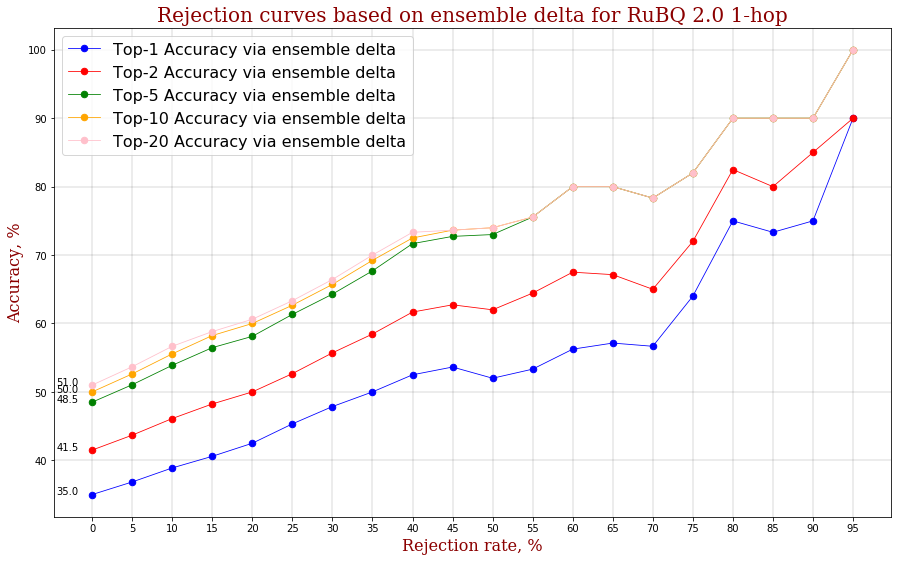

<Figure size 432x288 with 0 Axes>

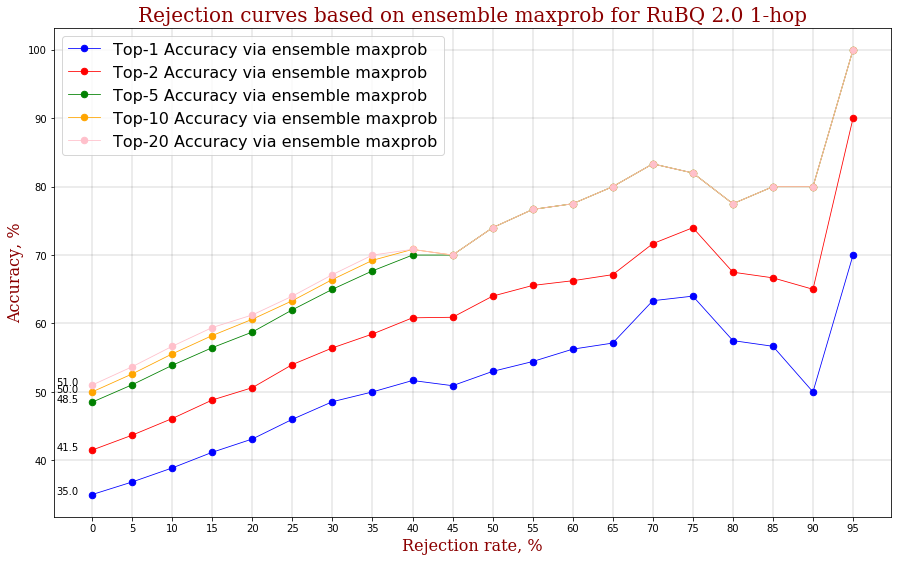

<Figure size 432x288 with 0 Axes>

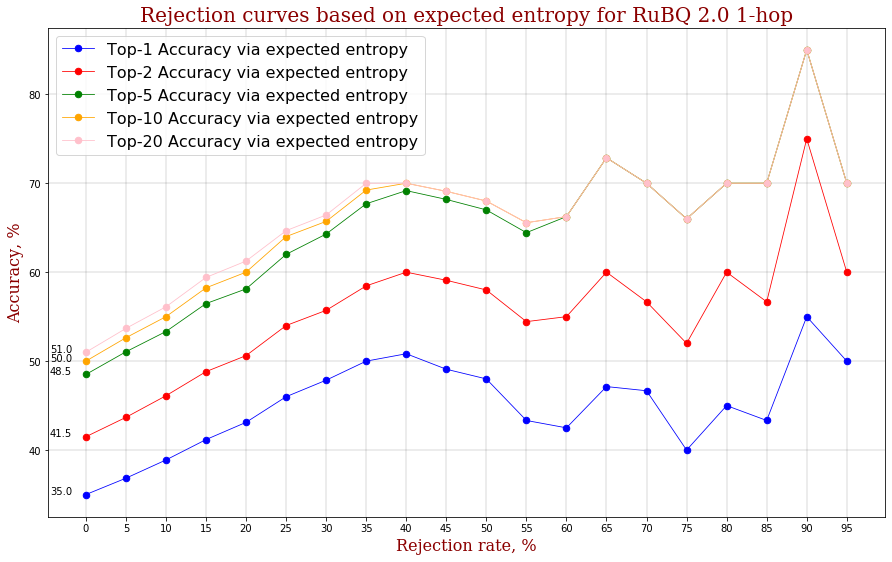

<Figure size 432x288 with 0 Axes>

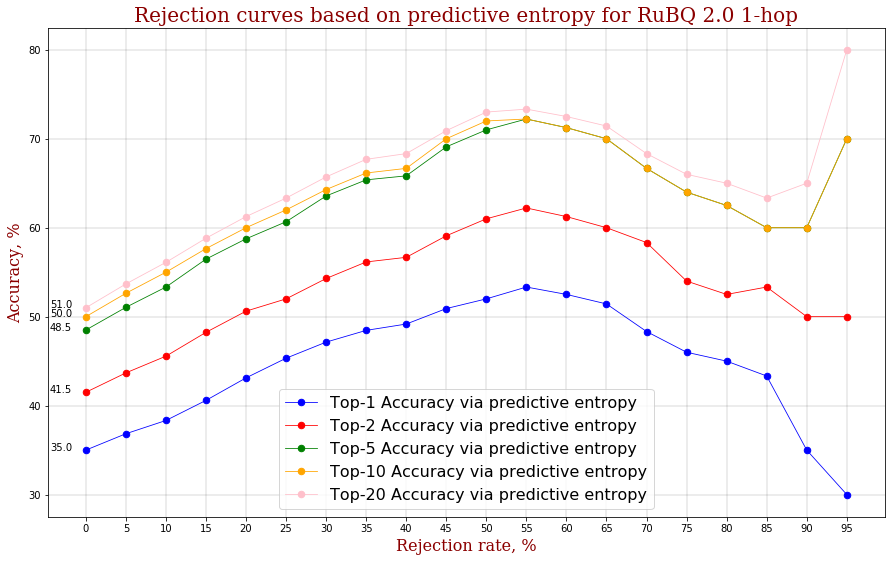

<Figure size 432x288 with 0 Axes>

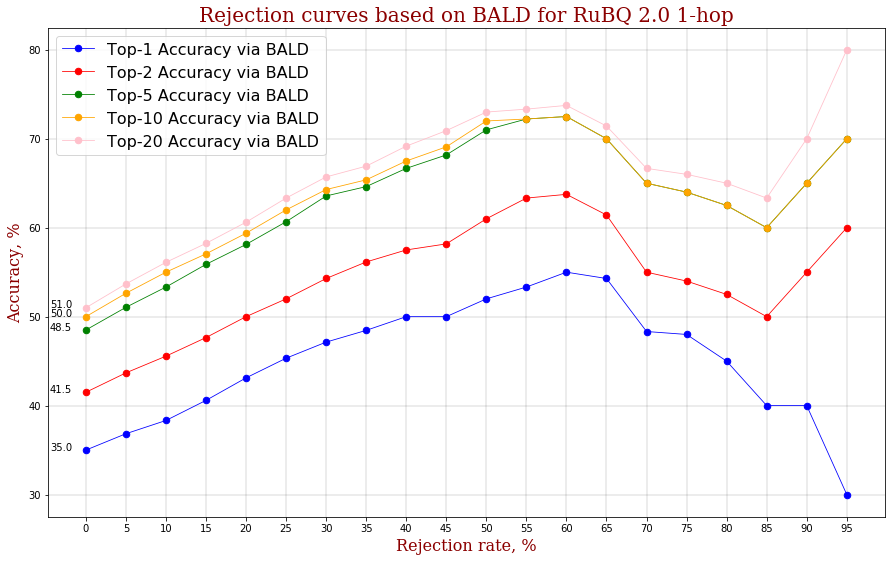

<Figure size 432x288 with 0 Axes>

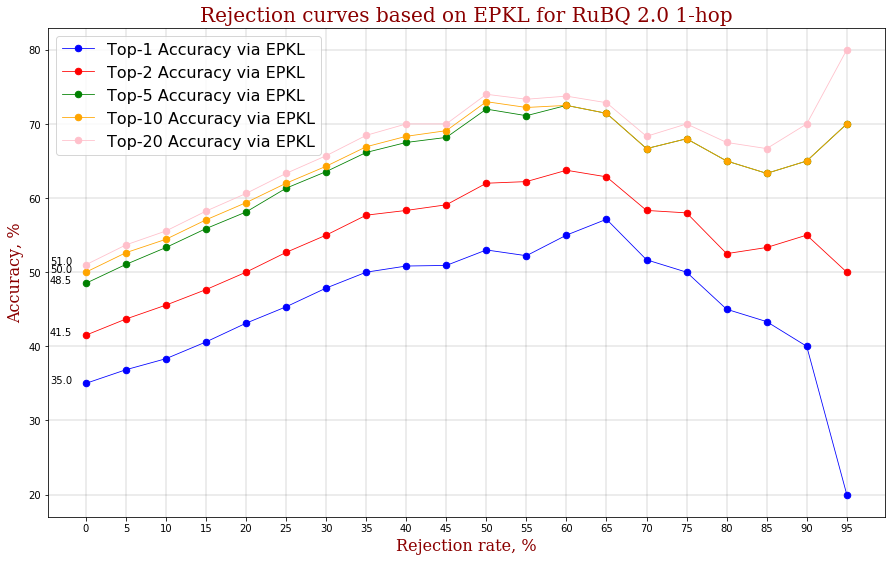

<Figure size 432x288 with 0 Axes>

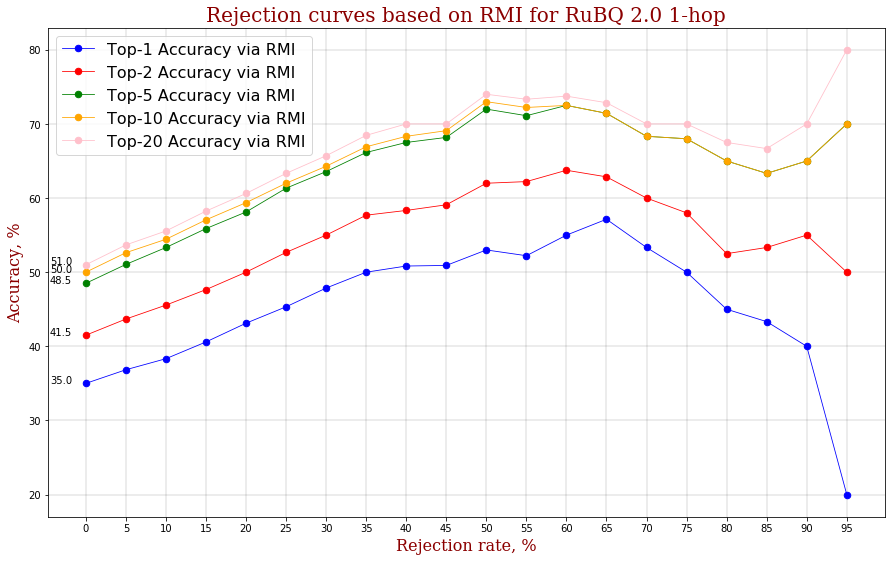

<Figure size 432x288 with 0 Axes>

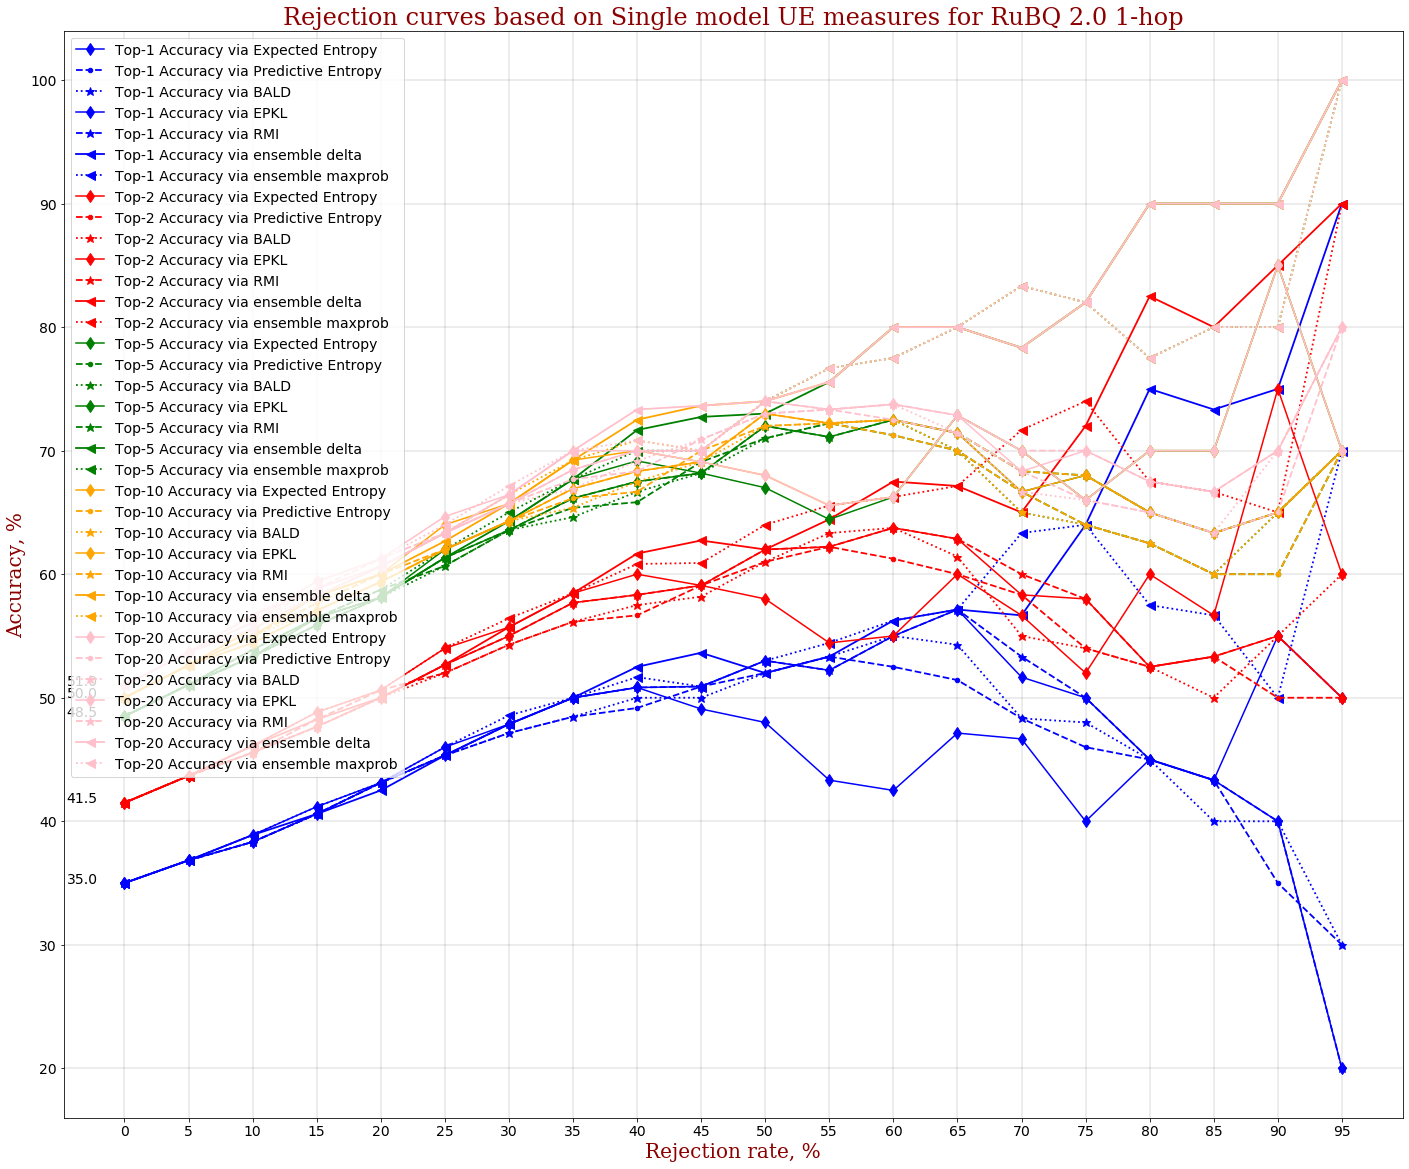

In [35]:
main_data_uncertainty, result_table = total_experiment_uncertainty_mc_dropout(

    data = list(rubq_test.question)[:200],
    answers = rubq_test_answers[:200],
    data_name = "RuBQ 2.0 1-hop",
    output_file_name = "RUBQ2_1HOP_TEST_DROPOUT_BS20",
    model = model,
    tokenizer = tokenizer,
    dropout_rate = 0.01,
    model_type = "T5_XL_SSM_NQ_model",
    num_quantiles = 20,
    seed = 42,
    ensemble_size = 5,
    num_beams = 20,
    need_report = False,
    plot_rejection_curves = True,
    top_ks = [1, 2, 5, 10, 20],
    top_k_to_plot = [1, 2, 5, 10, 20], 
    force_replace_zeros = False,
    max_sequence_length = 5
)

In [27]:
rubq_1hop_test_1186_mc_dropout_UE = obtain_probs_predicts_and_metrics_from_begin(
                                        data = data,
                                        data_name = "RuBQ 2.0 1-hop",
                                        number_of_questions = number_of_questions,
                                        model = t5_qa_model,
                                        tokenizer = t5_tok,
                                        device=device,
                                        seed = seed,
                                        ensemble_size = ensemble_size,
                                        num_beams = num_beams,
                                        need_report = need_report)

 23%|██▎       | 23/100 [00:18<01:02,  1.22it/s]


KeyboardInterrupt: 

In [40]:
res = rubq_1hop_test_1186_mc_dropout_UE["res"]
ensemble_deltas = rubq_1hop_test_1186_mc_dropout_UE["ensemble_deltas"]
ensemble_max_probs = rubq_1hop_test_1186_mc_dropout_UE["ensemble_max_probs"]
eentropies = rubq_1hop_test_1186_mc_dropout_UE["eentropies"]
pentropies = rubq_1hop_test_1186_mc_dropout_UE["pentropies"]
balds = rubq_1hop_test_1186_mc_dropout_UE["balds"]
epkls = rubq_1hop_test_1186_mc_dropout_UE["epkls"]
rmis = rubq_1hop_test_1186_mc_dropout_UE["rmis"]



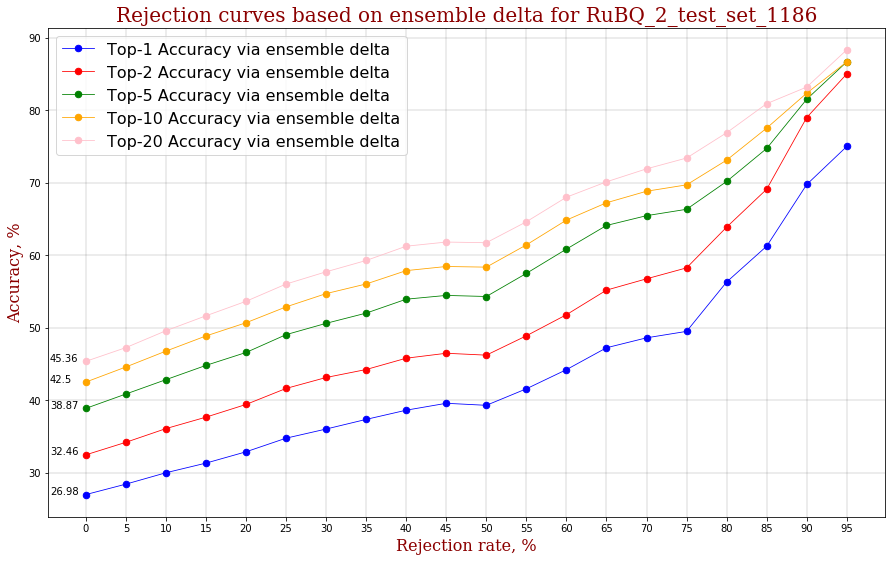

<Figure size 432x288 with 0 Axes>

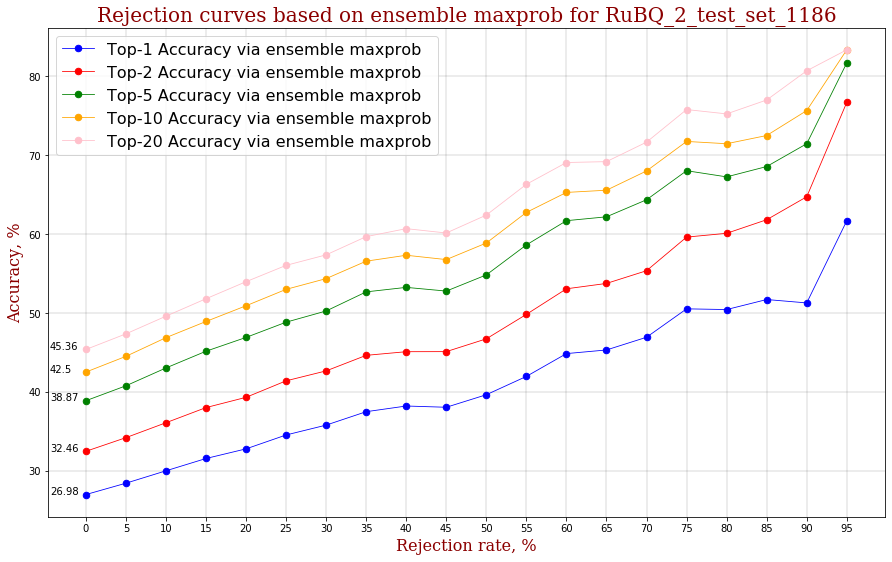

<Figure size 432x288 with 0 Axes>

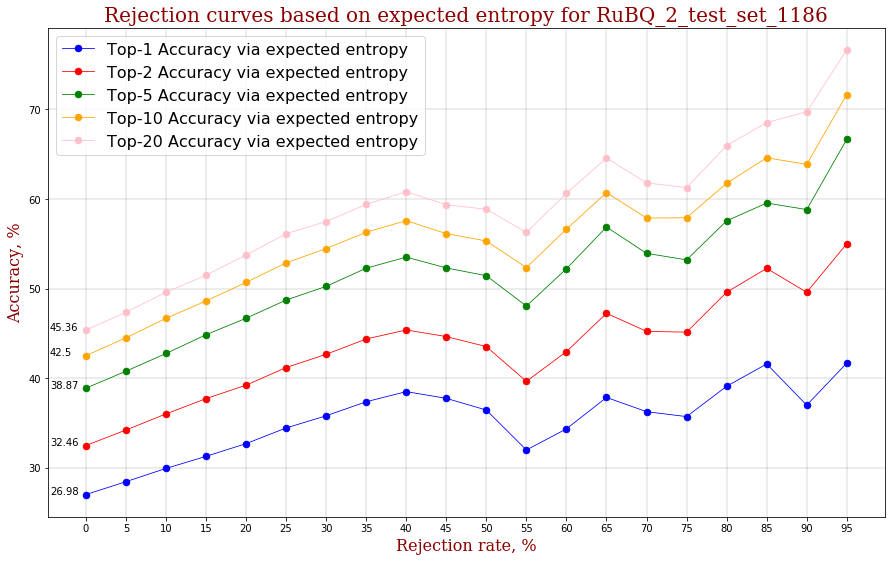

<Figure size 432x288 with 0 Axes>

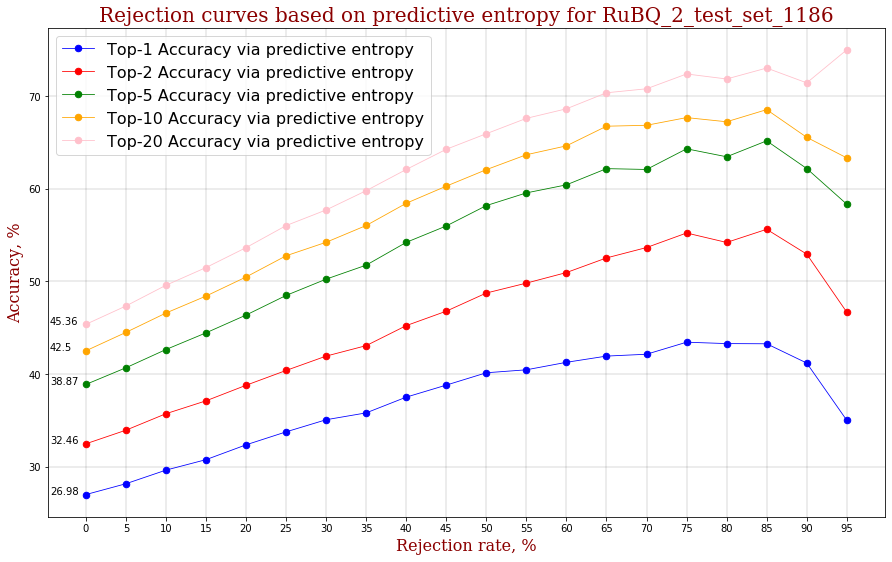

<Figure size 432x288 with 0 Axes>

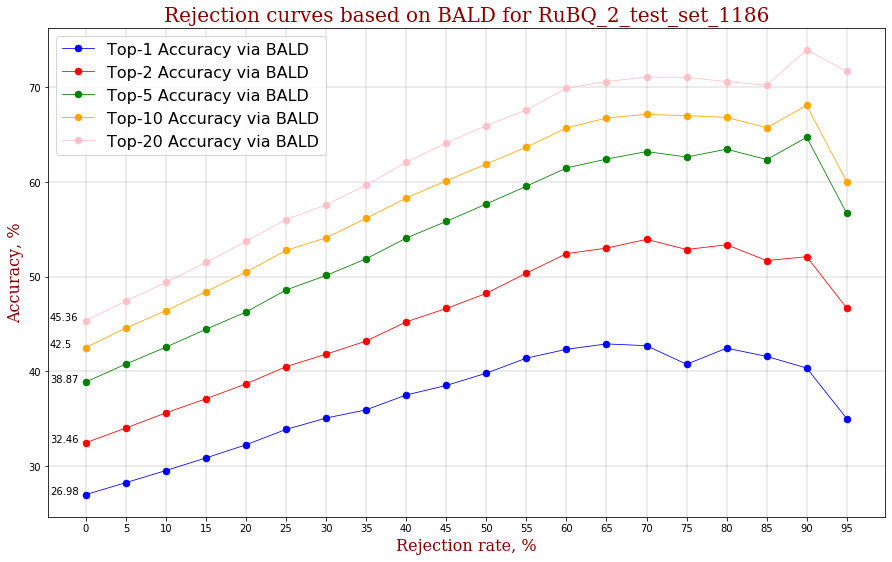

<Figure size 432x288 with 0 Axes>

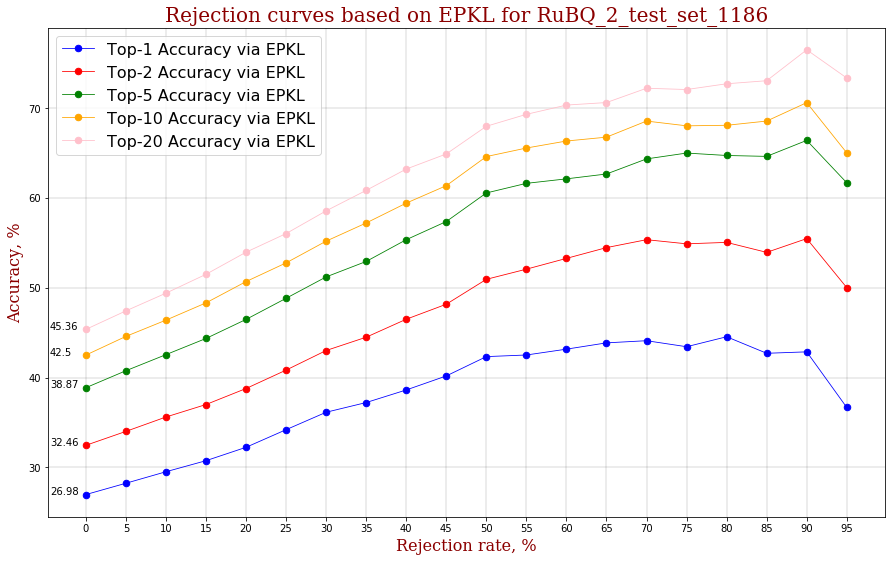

<Figure size 432x288 with 0 Axes>

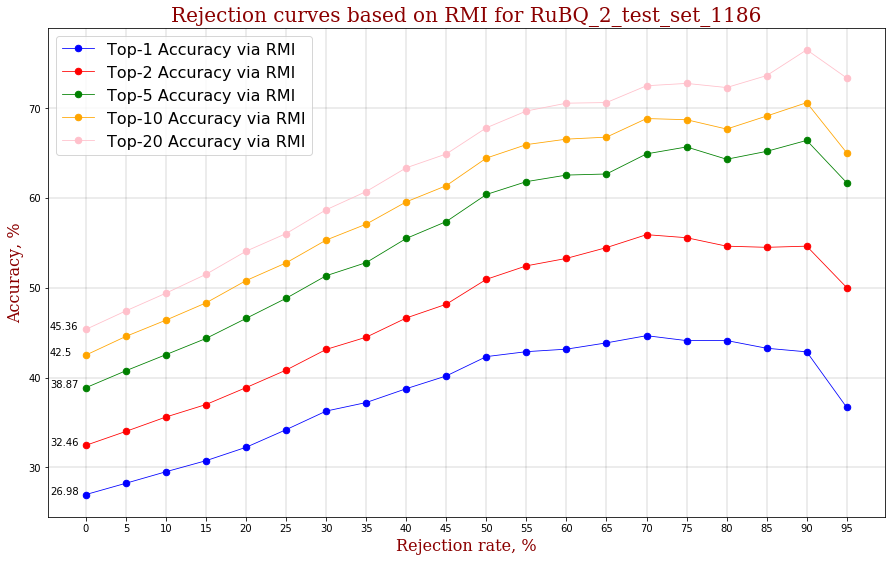

<Figure size 432x288 with 0 Axes>

In [46]:
accuracy_for_each_topk = {}

for metric in ["ensemble delta", "ensemble maxprob", "expected entropy", "predictive entropy", "BALD", "EPKL", "RMI"]:
    
    accuracy_for_each_topk_metric, ue_metrics = UE_ensemble(
                                                ensemble_metric_name = metric,
                                                answers = answers,
                                                dataset_name = "RuBQ_2_test_set_1186",
                                                plot_rejection_curves = True,
                                                predictions = res,
                                                num_quantiles = num_quantiles,
                                                ensemble_deltas = ensemble_deltas,
                                                ensemble_max_probs = ensemble_max_probs,
                                                eentropies = eentropies,
                                                pentropies = pentropies,
                                                balds = balds,
                                                epkls = epkls,
                                                rmis = rmis,
                                                top_ks = top_ks,
                                                model_type = "T5_XL_SSM_NQ_model",
                                                need_report = False)
    
    accuracy_for_each_topk[metric] = accuracy_for_each_topk_metric

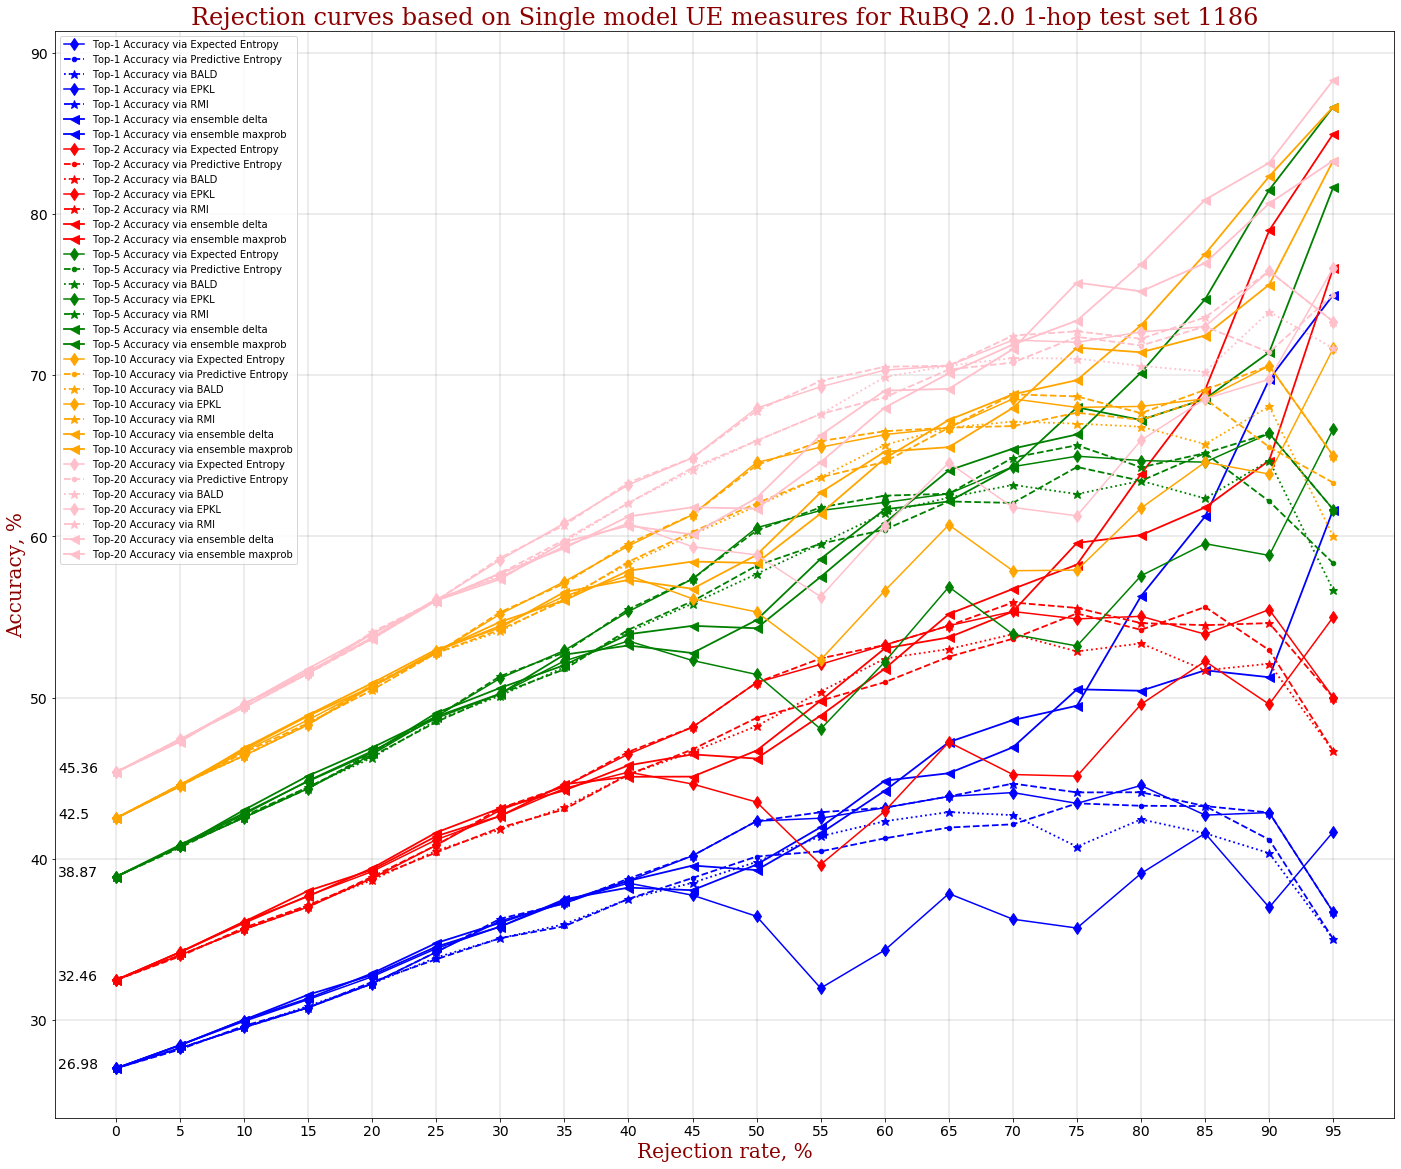

In [51]:
aggregation_plot_ensemble_measures(
    ue_metrics_to_plot = ["expected entropy", "predictive entropy", "BALD",
                          "EPKL", "RMI", "ensemble delta", "ensemble maxprob"],
    top_k_to_plot = [1,2,5,10,20],
    name_of_dataset = "RuBQ 2.0 1-hop test set 1186",
    accuracy_for_each_topk_ensemble_maxprob = accuracy_for_each_topk["ensemble maxprob"],
    accuracy_for_each_topk_ensemble_delta = accuracy_for_each_topk["ensemble delta"],
    accuracy_for_each_topk_eentropy = accuracy_for_each_topk["expected entropy"],
    accuracy_for_each_topk_pentropy = accuracy_for_each_topk["predictive entropy"],
    accuracy_for_each_topk_bald = accuracy_for_each_topk["BALD"],
    accuracy_for_each_topk_epkl = accuracy_for_each_topk["EPKL"],
    accuracy_for_each_topk_rmi = accuracy_for_each_topk["RMI"]
)

In [66]:
rubq_1hop_test_1186_mc_dropout_UE["ensemble maxprob"] = accuracy_for_each_topk["ensemble maxprob"]
rubq_1hop_test_1186_mc_dropout_UE["ensemble delta"] = accuracy_for_each_topk["ensemble delta"]
rubq_1hop_test_1186_mc_dropout_UE["expected entropy"] = accuracy_for_each_topk["expected entropy"]
rubq_1hop_test_1186_mc_dropout_UE["predictive entropy"] = accuracy_for_each_topk["predictive entropy"]
rubq_1hop_test_1186_mc_dropout_UE["BALD"] = accuracy_for_each_topk["BALD"]
rubq_1hop_test_1186_mc_dropout_UE["EPKL"] = accuracy_for_each_topk["EPKL"]
rubq_1hop_test_1186_mc_dropout_UE["RMI"] = accuracy_for_each_topk["RMI"]
rubq_1hop_test_1186_mc_dropout_UE["top_ks"] = top_ks
rubq_1hop_test_1186_mc_dropout_UE["seed"] = seed
rubq_1hop_test_1186_mc_dropout_UE["num_quantiles"] = num_quantiles

In [67]:
# with open('RUBQ2_1HOP_1186_MC_DROPOUT_BS20.pkl', 'wb') as handle:
#     pickle.dump(rubq_1hop_test_1186_mc_dropout_UE, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [87]:
with open('RUBQ2_1HOP_1186_MC_DROPOUT_BS20.pkl', 'rb') as handle:
    data = pickle.load(handle)

names = [
    "ensemble maxprob",
    "ensemble delta",
    "expected entropy",
    "predictive entropy",
    "BALD",
    "EPKL",
    "RMI"
]

dropout_data = [[area_under_rejection_curve(data = data, name = name, topk=topk, num_quantiles = data["num_quantiles"]) for topk in data["top_ks"]] for name in names]


df = pd.DataFrame(dropout_data)
df["UE"] = ["score", "delta", "eentropy", "pentropy", "bald", "epkl", "rmi"]
df.set_index("UE", inplace=True)
df.columns = ["{} top-1 acc".format(data["data_name"]), "{} top-2 acc".format(data["data_name"]),
              "{} top-5 acc".format(data["data_name"]), "{} top-10 acc".format(data["data_name"]),
              "{} top-20 acc".format(data["data_name"])]
mux = pd.MultiIndex.from_product([["{}".format(data["data_name"])], ['top-1 acc', 'top-2 acc', 'top-5 acc', 'top-10 acc', 'top-20 acc']])

dta = df.reset_index()[["{} top-1 acc".format(data["data_name"]), "{} top-2 acc".format(data["data_name"]),
              "{} top-5 acc".format(data["data_name"]), "{} top-10 acc".format(data["data_name"]),
              "{} top-20 acc".format(data["data_name"])]]

result_table = pd.DataFrame(np.array(dta), columns=mux)
result_table["Model"] = ["EoP"]*7
result_table["Beam Size"] = data["num_beams"]
result_table["UE"] = ["score", "delta", "eentropy", "pentropy", "bald", "epkl", "rmi"]

result_table = result_table[["Model", "Beam Size", "UE", "{}".format(data["data_name"])]]
result_table




Model Beam Size        UE RuBQ 2.0 1-hop                                 \
                                 top-1 acc top-2 acc top-5 acc top-10 acc   
0   EoP        20     score         0.4072    0.4873    0.5635     0.6019   
1   EoP        20     delta         0.4303    0.5033    0.5751     0.6099   
2   EoP        20  eentropy         0.3528    0.4337    0.5139     0.5557   
3   EoP        20  pentropy         0.3736    0.4611    0.5478     0.5882   
4   EoP        20      bald         0.3720    0.4580    0.5472     0.5870   
5   EoP        20      epkl         0.3834    0.4710    0.5589     0.5982   
6   EoP        20       rmi         0.3844    0.4717    0.5600     0.5991   

              
  top-20 acc  
0     0.6358  
1     0.6399  
2     0.5916  
3     0.6285  
4     0.6268  
5     0.6367  
6     0.6376

# RuBQ 2.0 1-hop (1186 questions) beam size = 10

In [23]:
# data
rubq_test = np.load("all_EN_rubq_test_questions_1_hop_uri.npy")
rubq_answers = np.load("all_rubq_test_answers_1_hop_uri.npy", allow_pickle=True)
entities_test_rubq = np.load("entities_test_rubq.npy")
rubq_test_answers = np.load("all_rubq_test_answers_1_hop_uri.npy", allow_pickle=True)
rubq_test = pd.DataFrame({"subject":entities_test_rubq, "question":rubq_test})
number_of_questions = len(rubq_test)

  0%|          | 2/1186 [00:01<15:37,  1.26it/s]


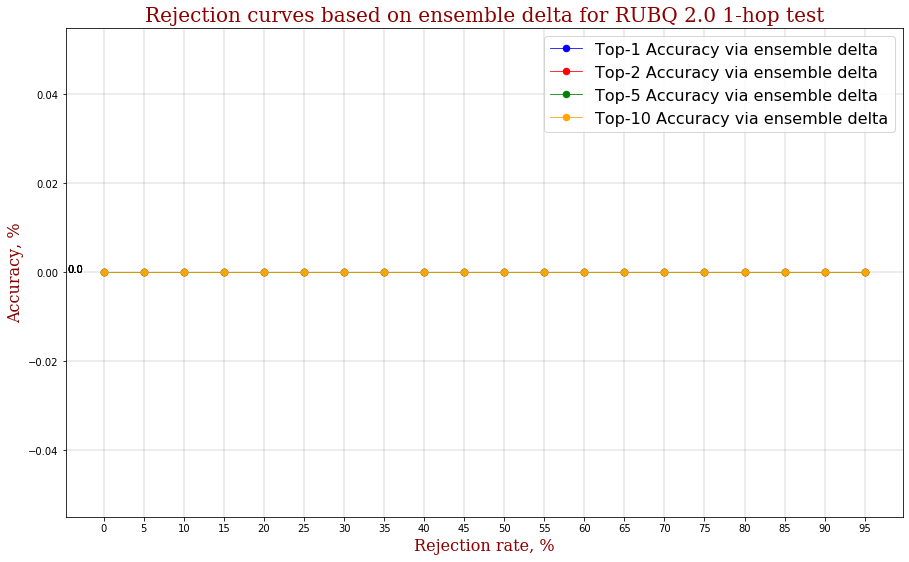

<Figure size 432x288 with 0 Axes>

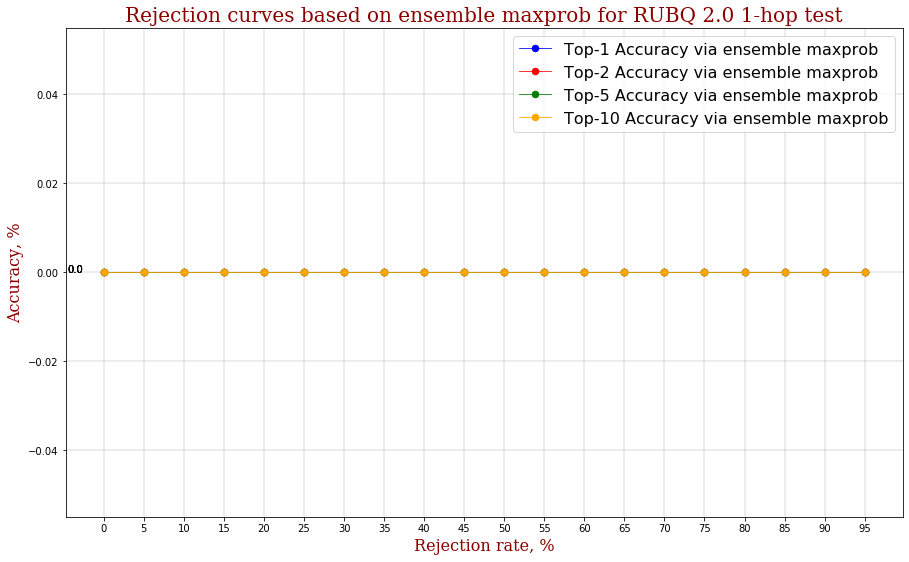

<Figure size 432x288 with 0 Axes>

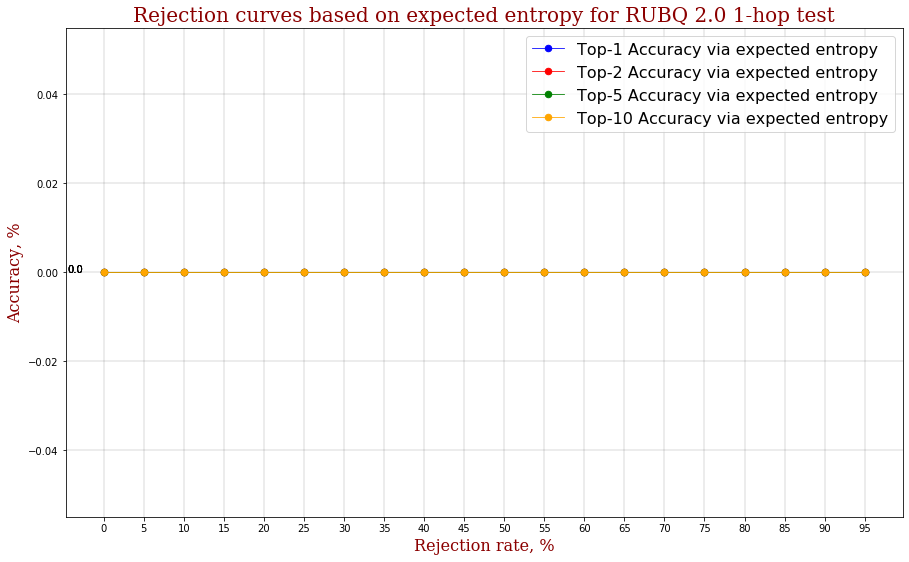

<Figure size 432x288 with 0 Axes>

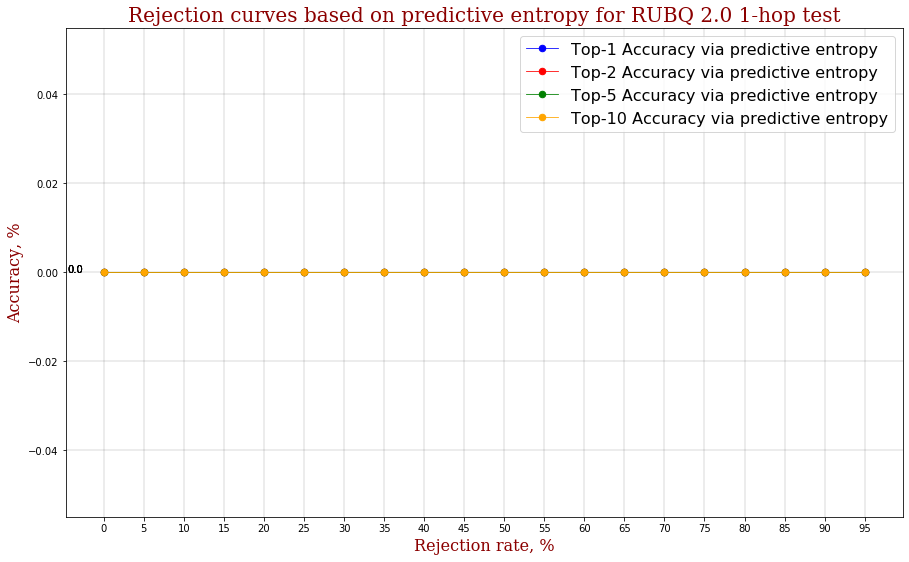

<Figure size 432x288 with 0 Axes>

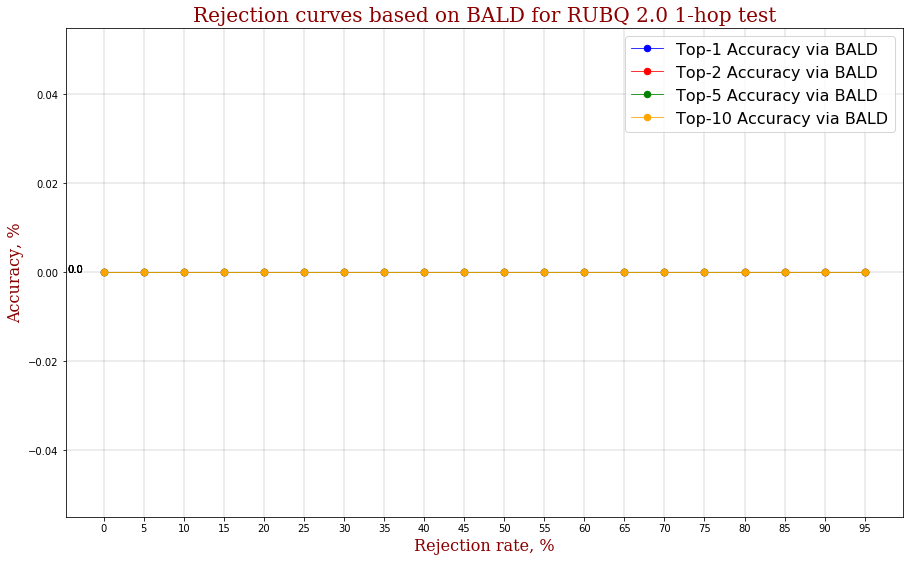

<Figure size 432x288 with 0 Axes>

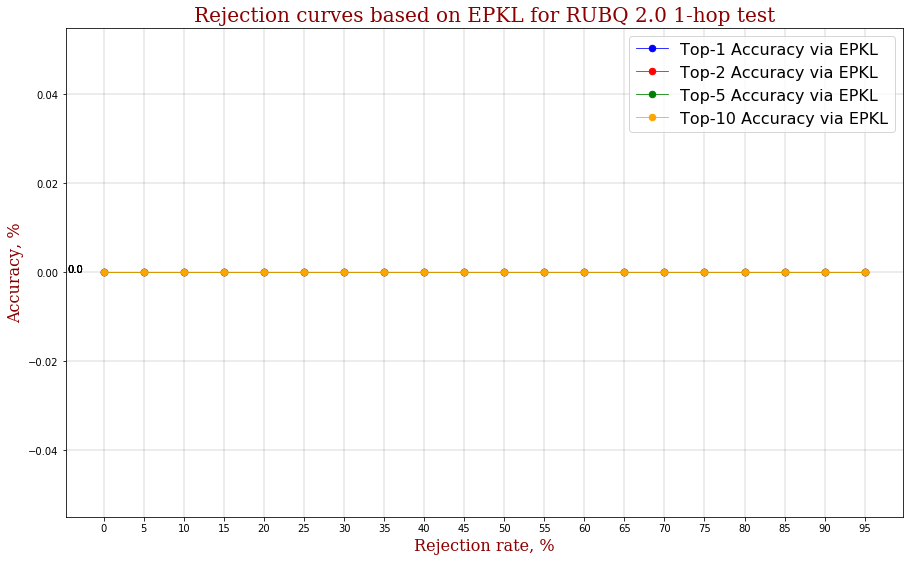

<Figure size 432x288 with 0 Axes>

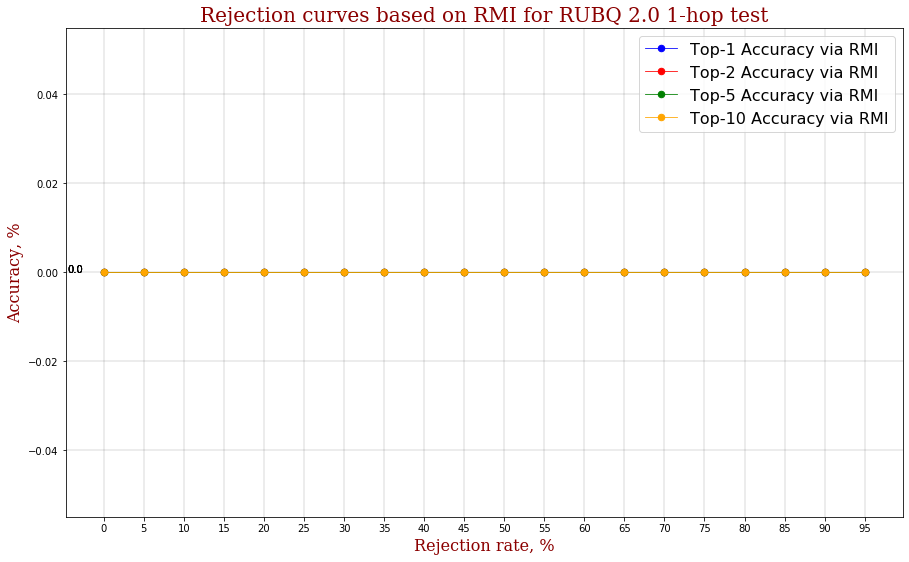

Model Beam Size        UE RUBQ 2.0 1-hop test                               
                                      top-1 acc top-2 acc top-5 acc top-10 acc
0   EoP        10     score                 0.0       0.0       0.0        0.0
1   EoP        10     delta                 0.0       0.0       0.0        0.0
2   EoP        10  eentropy                 0.0       0.0       0.0        0.0
3   EoP        10  pentropy                 0.0       0.0       0.0        0.0
4   EoP        10      bald                 0.0       0.0       0.0        0.0
5   EoP        10      epkl                 0.0       0.0       0.0        0.0
6   EoP        10       rmi                 0.0       0.0       0.0        0.0

<Figure size 432x288 with 0 Axes>

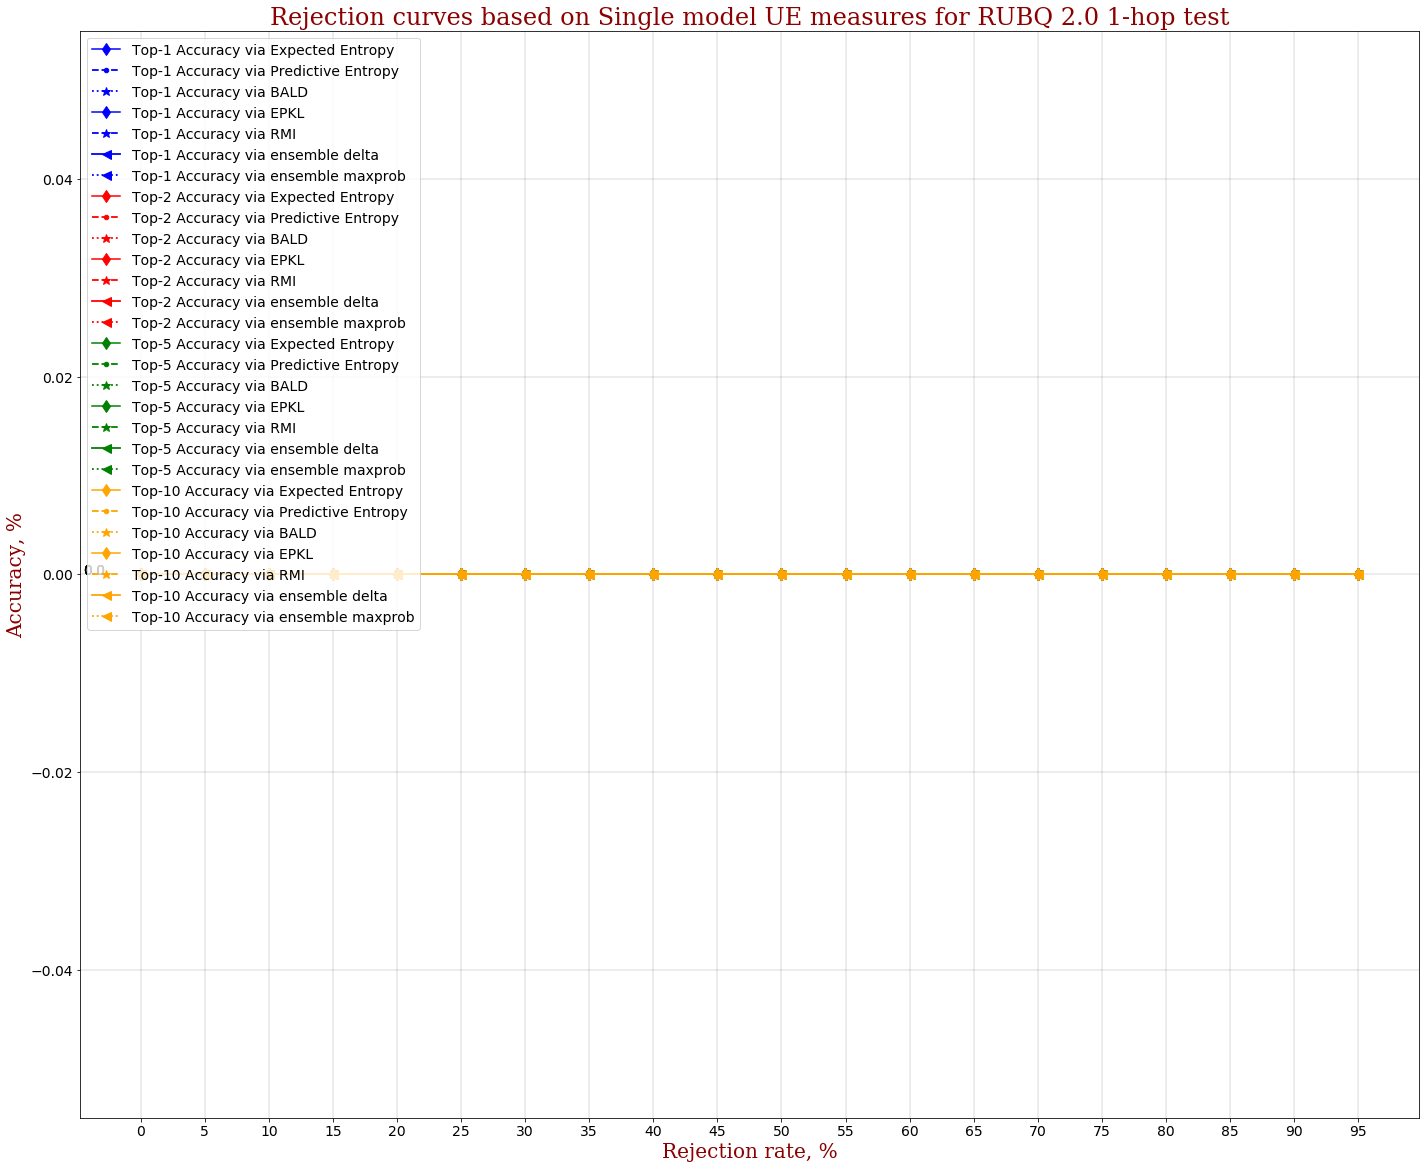

In [24]:
main_data_uncertainty, result_table = total_experiment_uncertainty_mc_dropout(

    data = rubq_test,
    answers = rubq_test_answers,
    number_of_questions = number_of_questions,
    data_name = "RUBQ 2.0 1-hop test",
    output_file_name = "RUBQ2_1HOP_TEST_DROPOUT_BS10",
    model = t5_qa_model,
    tokenizer = t5_tok,
    model_type = "T5_XL_SSM_NQ_model",
    num_quantiles = 20,
    seed = 42,
    ensemble_size = 5,
    num_beams = 10,
    need_report = False,
    plot_rejection_curves = True,
    top_ks = [1, 2, 5, 10],
    top_k_to_plot = [1, 2, 5, 10],
    
    
)

result_table

#  SQ In Graph beam size = 10

In [101]:
sq_mask = np.load("sq_mask_present_in_graph.npy")
sq_test = list(np.load("simple_questions_test.npy")[:,3])
sq_test_answers = np.array([[el] for el in list(np.load("simple_questions_test.npy")[:,2])])

# mask
sq_test = list(compress(sq_test, sq_mask))
sq_test_answers = np.array(list((compress(sq_test_answers, sq_mask))))

In [102]:
number_of_questions = len(sq_test)#2438
num_quantiles = 20
data_name = "SQ in graph"
seed = 42
ensemble_size = 5
num_beams = 10
need_report = False
data = sq_test
top_ks = [1, 2, 5, 10]
answers = sq_test_answers

In [103]:
sq_in_graph_mc_dropout_UE_bs_10 = obtain_probs_predicts_and_metrics_from_begin(
                                        data = data,
                                        data_name = "SQ in graph",
                                        number_of_questions = number_of_questions,
                                        model = t5_qa_model,
                                        tokenizer = t5_tok,
                                        device=device,
                                        seed = seed,
                                        ensemble_size = ensemble_size,
                                        num_beams = num_beams,
                                        need_report = need_report)

100%|██████████| 2438/2438 [1:08:15<00:00,  1.68s/it]


In [104]:
res = sq_in_graph_mc_dropout_UE_bs_10["res"]
ensemble_deltas = sq_in_graph_mc_dropout_UE_bs_10["ensemble_deltas"]
ensemble_max_probs = sq_in_graph_mc_dropout_UE_bs_10["ensemble_max_probs"]
eentropies = sq_in_graph_mc_dropout_UE_bs_10["eentropies"]
pentropies = sq_in_graph_mc_dropout_UE_bs_10["pentropies"]
balds = sq_in_graph_mc_dropout_UE_bs_10["balds"]
epkls = sq_in_graph_mc_dropout_UE_bs_10["epkls"]
rmis = sq_in_graph_mc_dropout_UE_bs_10["rmis"]



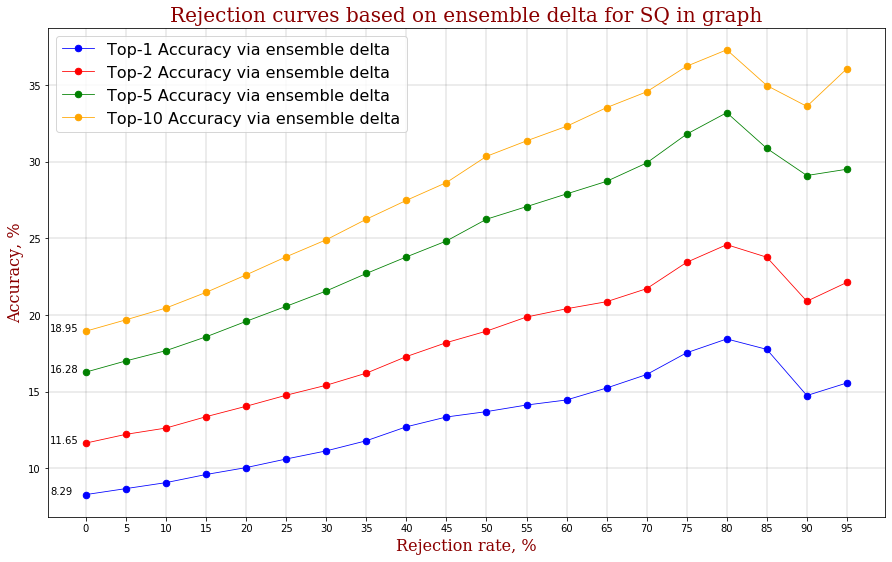

<Figure size 432x288 with 0 Axes>

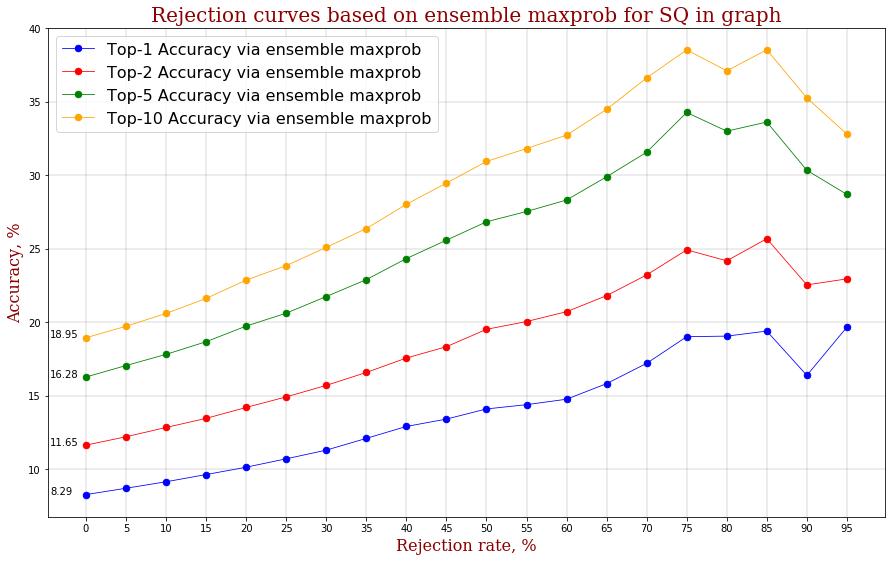

<Figure size 432x288 with 0 Axes>

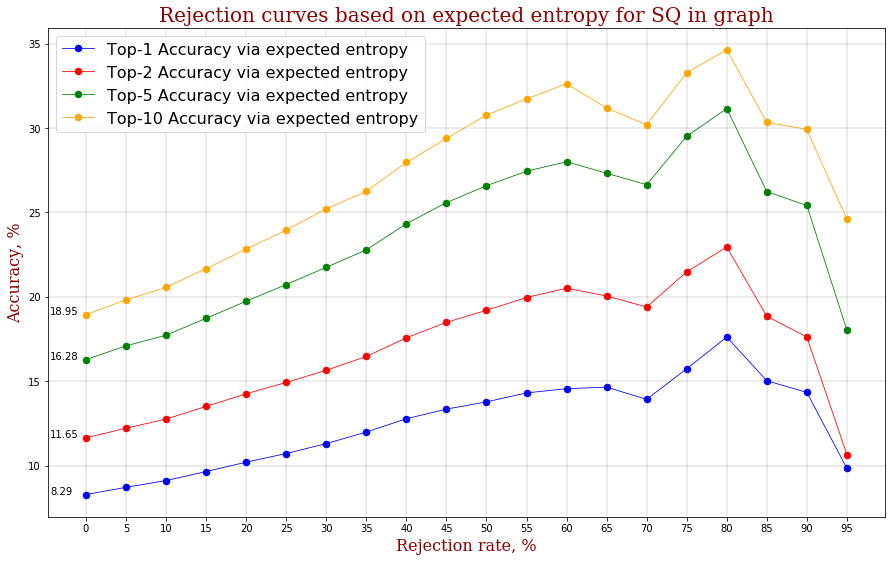

<Figure size 432x288 with 0 Axes>

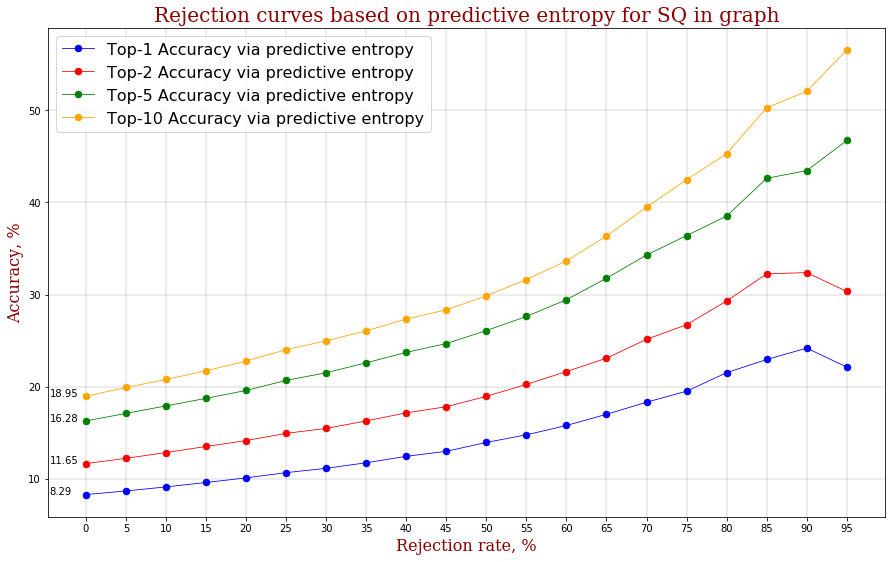

<Figure size 432x288 with 0 Axes>

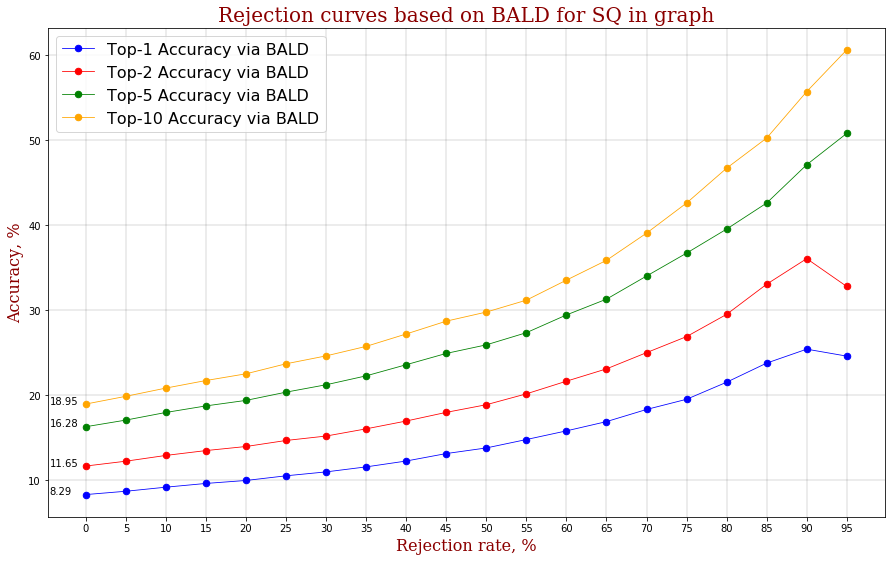

<Figure size 432x288 with 0 Axes>

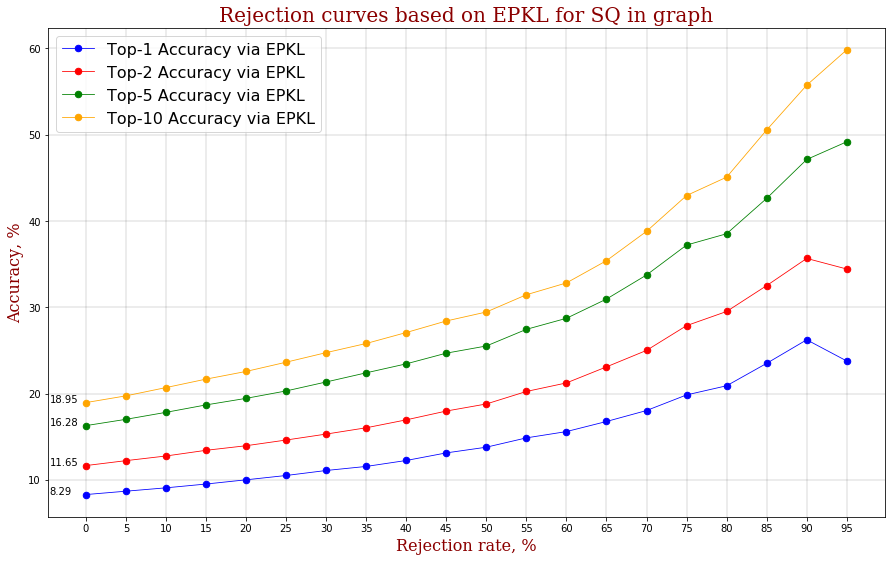

<Figure size 432x288 with 0 Axes>

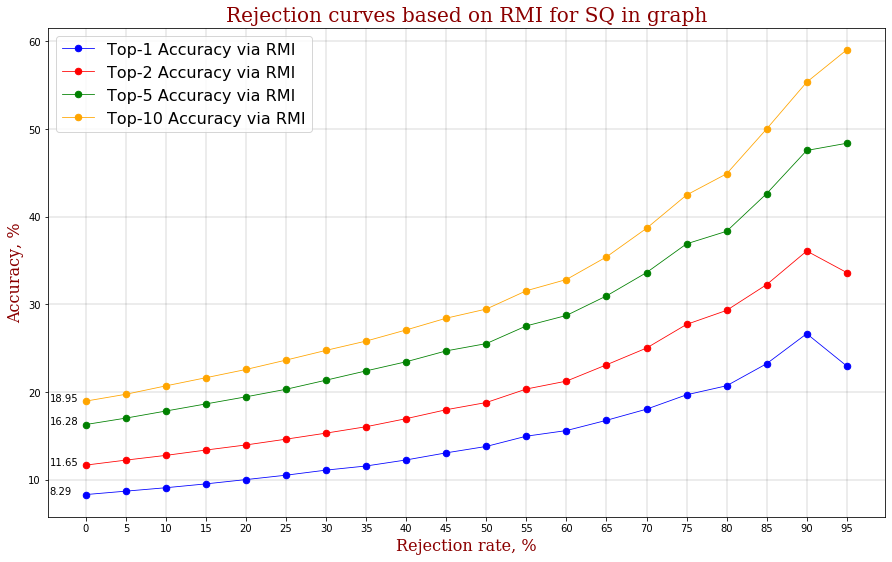

Model Beam Size        UE SQ in graph                               
                              top-1 acc top-2 acc top-5 acc top-10 acc
0   EoP        10     score      0.1381    0.1873    0.2559     0.2944
1   EoP        10     delta      0.1321    0.1819    0.2495     0.2879
2   EoP        10  eentropy      0.1268    0.1721    0.2389     0.2758
3   EoP        10  pentropy      0.1472    0.2027    0.2780     0.3235
4   EoP        10      bald      0.1484    0.2052    0.2806     0.3260
5   EoP        10      epkl      0.1480    0.2053    0.2788     0.3242
6   EoP        10       rmi      0.1477    0.2050    0.2785     0.3230

<Figure size 432x288 with 0 Axes>

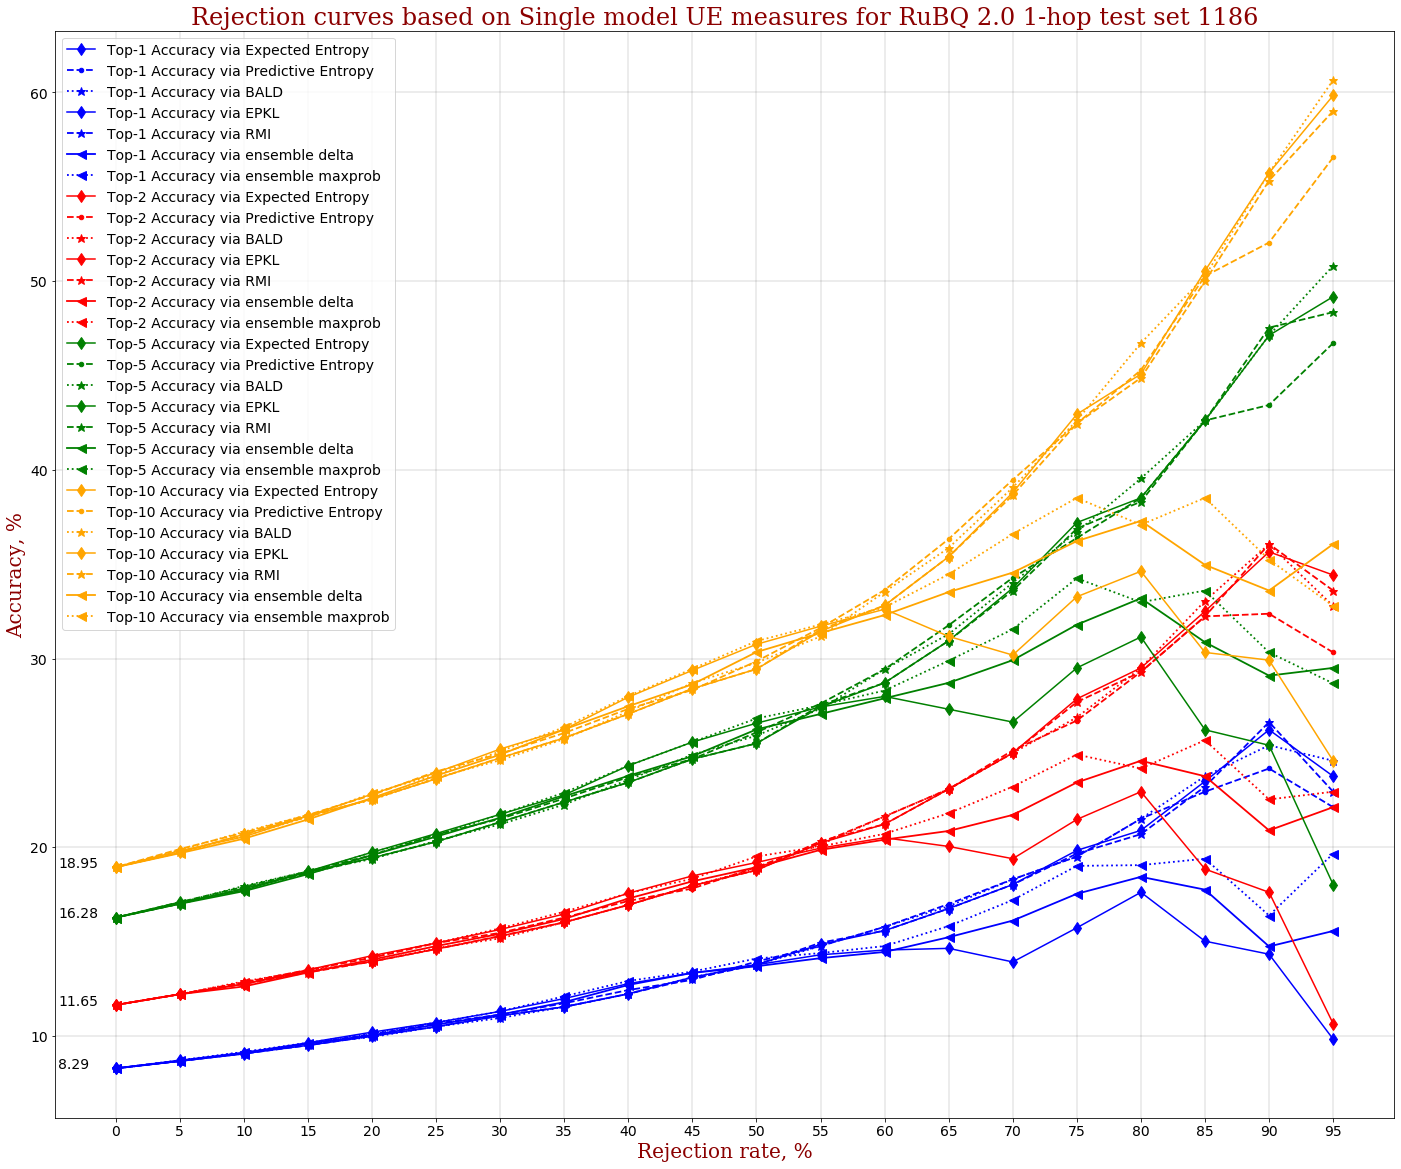

In [116]:
accuracy_for_each_topk = {}

for metric in ["ensemble delta", "ensemble maxprob", "expected entropy", "predictive entropy", "BALD", "EPKL", "RMI"]:
    
    accuracy_for_each_topk_metric, ue_metrics = UE_ensemble(
                                                ensemble_metric_name = metric,
                                                answers = answers,
                                                dataset_name = "SQ in graph",
                                                plot_rejection_curves = True,
                                                predictions = res,
                                                num_quantiles = num_quantiles,
                                                ensemble_deltas = ensemble_deltas,
                                                ensemble_max_probs = ensemble_max_probs,
                                                eentropies = eentropies,
                                                pentropies = pentropies,
                                                balds = balds,
                                                epkls = epkls,
                                                rmis = rmis,
                                                top_ks = top_ks,
                                                model_type = "T5_XL_SSM_NQ_model",
                                                need_report = False)
    
    accuracy_for_each_topk[metric] = accuracy_for_each_topk_metric
    
aggregation_plot_ensemble_measures(
    ue_metrics_to_plot = ["expected entropy", "predictive entropy", "BALD",
                          "EPKL", "RMI", "ensemble delta", "ensemble maxprob"],
    top_k_to_plot = [1,2,5,10],
    name_of_dataset = "RuBQ 2.0 1-hop test set 1186",
    accuracy_for_each_topk_ensemble_maxprob = accuracy_for_each_topk["ensemble maxprob"],
    accuracy_for_each_topk_ensemble_delta = accuracy_for_each_topk["ensemble delta"],
    accuracy_for_each_topk_eentropy = accuracy_for_each_topk["expected entropy"],
    accuracy_for_each_topk_pentropy = accuracy_for_each_topk["predictive entropy"],
    accuracy_for_each_topk_bald = accuracy_for_each_topk["BALD"],
    accuracy_for_each_topk_epkl = accuracy_for_each_topk["EPKL"],
    accuracy_for_each_topk_rmi = accuracy_for_each_topk["RMI"]
)


sq_in_graph_mc_dropout_UE_bs_10["ensemble maxprob"] = accuracy_for_each_topk["ensemble maxprob"]
sq_in_graph_mc_dropout_UE_bs_10["ensemble delta"] = accuracy_for_each_topk["ensemble delta"]
sq_in_graph_mc_dropout_UE_bs_10["expected entropy"] = accuracy_for_each_topk["expected entropy"]
sq_in_graph_mc_dropout_UE_bs_10["predictive entropy"] = accuracy_for_each_topk["predictive entropy"]
sq_in_graph_mc_dropout_UE_bs_10["BALD"] = accuracy_for_each_topk["BALD"]
sq_in_graph_mc_dropout_UE_bs_10["EPKL"] = accuracy_for_each_topk["EPKL"]
sq_in_graph_mc_dropout_UE_bs_10["RMI"] = accuracy_for_each_topk["RMI"]
sq_in_graph_mc_dropout_UE_bs_10["top_ks"] = top_ks
sq_in_graph_mc_dropout_UE_bs_10["seed"] = seed
sq_in_graph_mc_dropout_UE_bs_10["num_quantiles"] = num_quantiles

#save data
with open('SQ_In_GRAPH_MC_DROPOUT_BS10.pkl', 'wb') as handle:
    pickle.dump(sq_in_graph_mc_dropout_UE_bs_10, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
#load data
with open('SQ_In_GRAPH_MC_DROPOUT_BS10.pkl', 'rb') as handle:
    data = pickle.load(handle)

names = [
    "ensemble maxprob",
    "ensemble delta",
    "expected entropy",
    "predictive entropy",
    "BALD",
    "EPKL",
    "RMI"
]

dropout_data = [[area_under_rejection_curve(data = data, name = name, topk=topk, num_quantiles = data["num_quantiles"]) for topk in data["top_ks"]] for name in names]


df = pd.DataFrame(dropout_data)
df["UE"] = ["score", "delta", "eentropy", "pentropy", "bald", "epkl", "rmi"]
df.set_index("UE", inplace=True)
df.columns = ["{} top-1 acc".format(data["data_name"]), "{} top-2 acc".format(data["data_name"]),
              "{} top-5 acc".format(data["data_name"]), "{} top-10 acc".format(data["data_name"])]
mux = pd.MultiIndex.from_product([["{}".format(data["data_name"])], ['top-1 acc', 'top-2 acc', 'top-5 acc', 'top-10 acc']])

dta = df.reset_index()[["{} top-1 acc".format(data["data_name"]), "{} top-2 acc".format(data["data_name"]),
              "{} top-5 acc".format(data["data_name"]), "{} top-10 acc".format(data["data_name"])]]

result_table = pd.DataFrame(np.array(dta), columns=mux)
result_table["Model"] = ["EoP"]*7
result_table["Beam Size"] = data["num_beams"]
result_table["UE"] = ["score", "delta", "eentropy", "pentropy", "bald", "epkl", "rmi"]

result_table = result_table[["Model", "Beam Size", "UE", "{}".format(data["data_name"])]]

result_table.to_csv(f'AURC_SQ_In_GRAPH_MC_DROPOUT_BS10.csv', index=False)
result_table




# SQ In Graph beam size = 20

100%|██████████| 2438/2438 [35:39<00:00,  1.14it/s] 


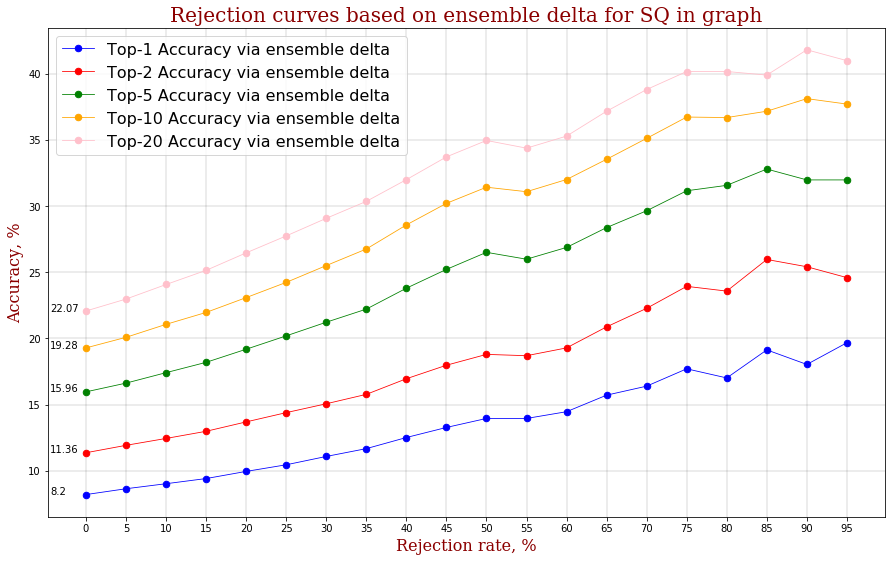

<Figure size 432x288 with 0 Axes>

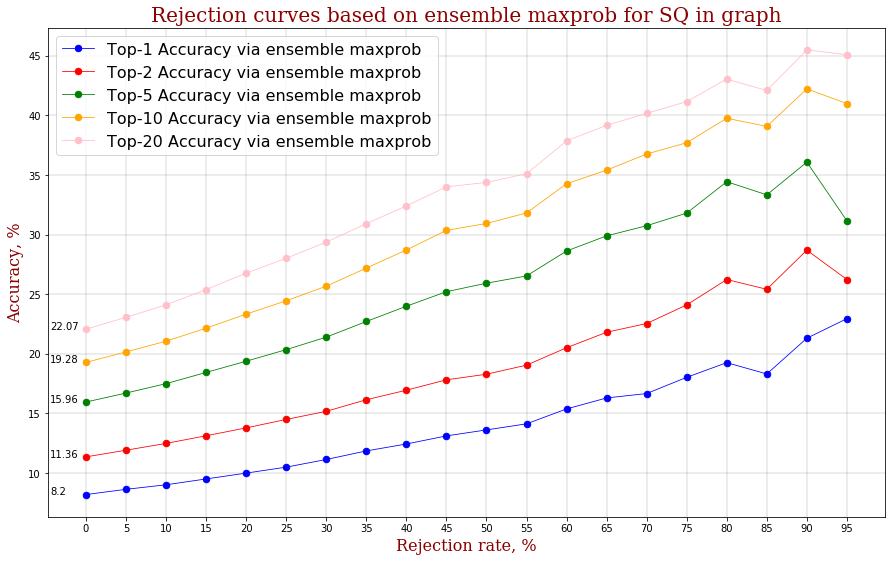

<Figure size 432x288 with 0 Axes>

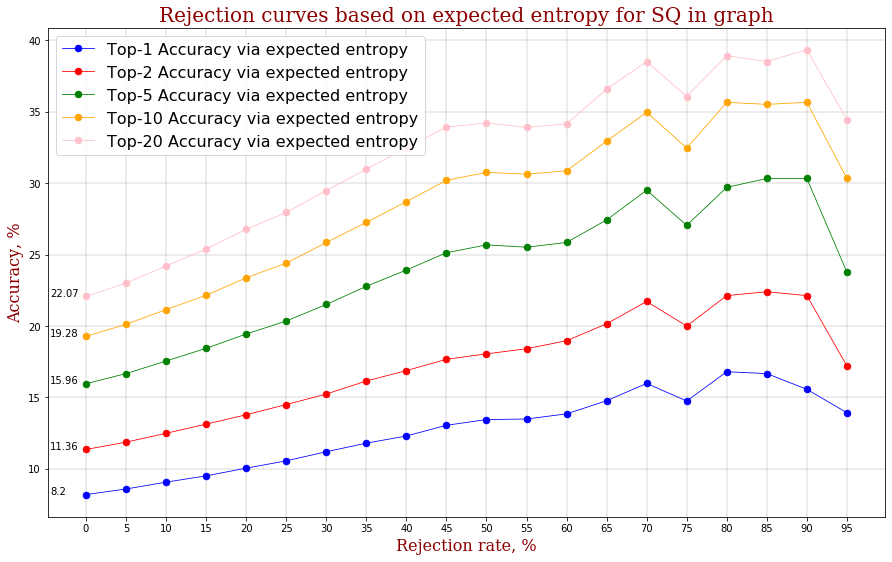

<Figure size 432x288 with 0 Axes>

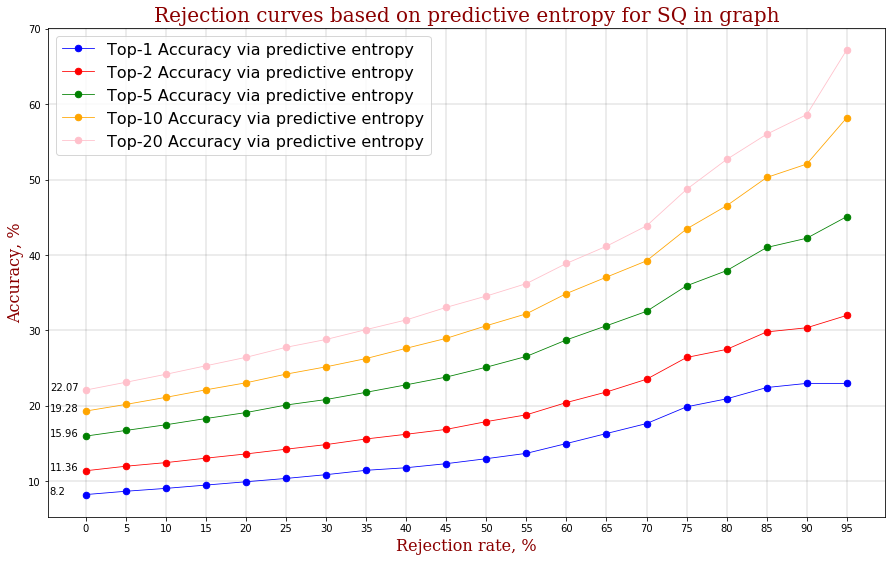

<Figure size 432x288 with 0 Axes>

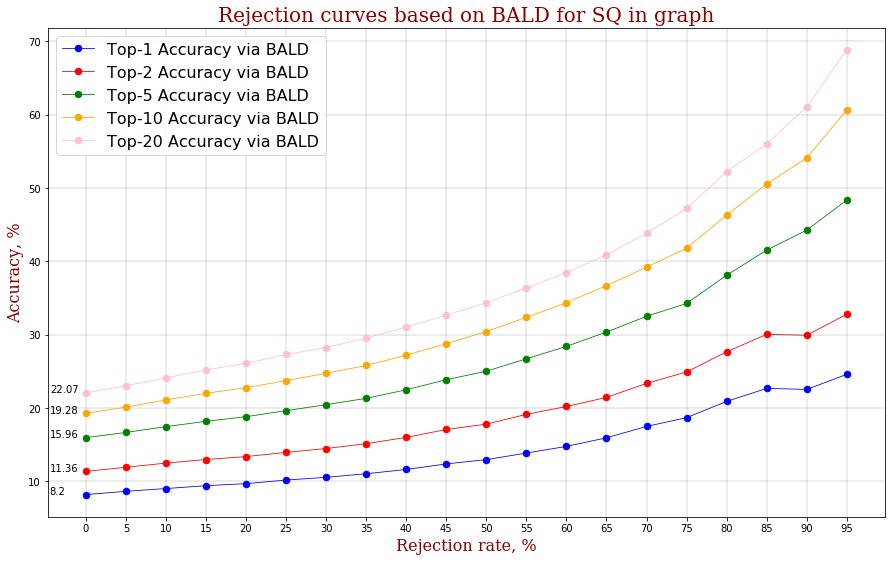

<Figure size 432x288 with 0 Axes>

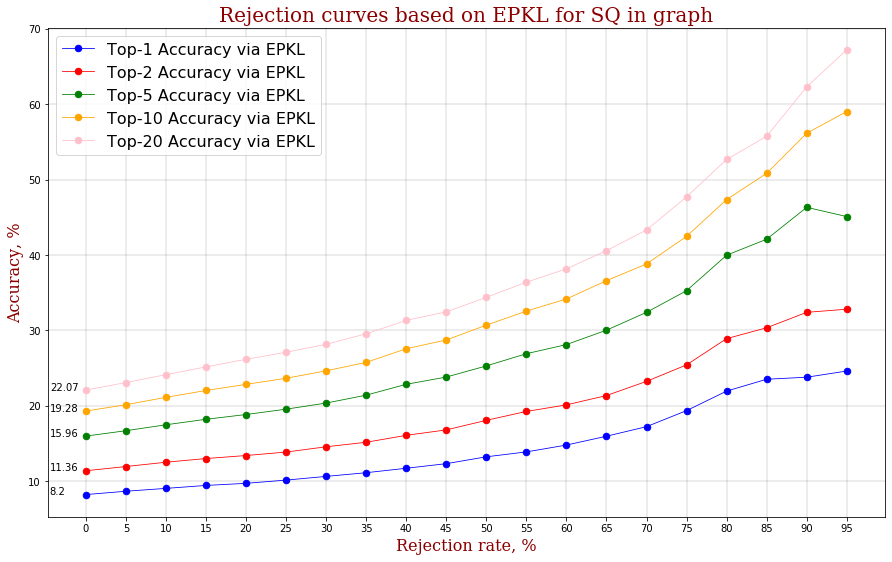

<Figure size 432x288 with 0 Axes>

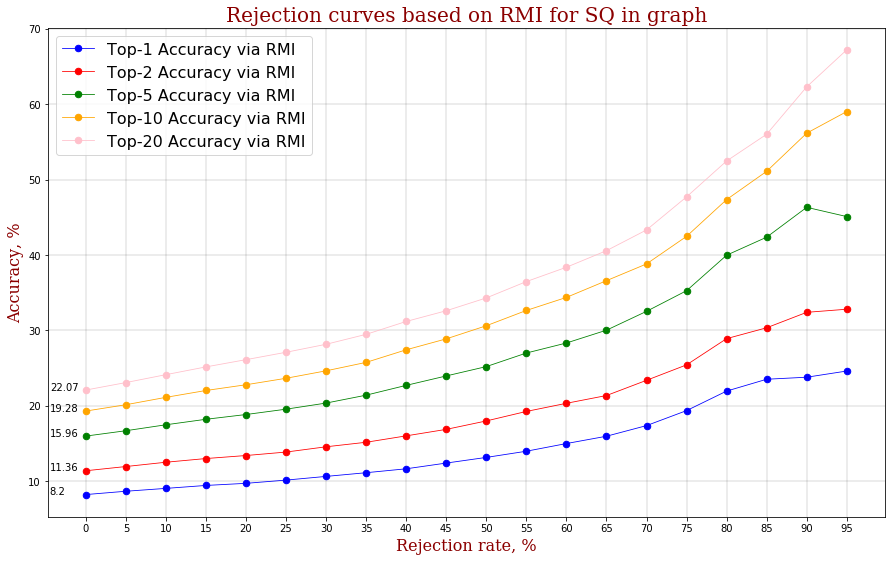

<Figure size 432x288 with 0 Axes>

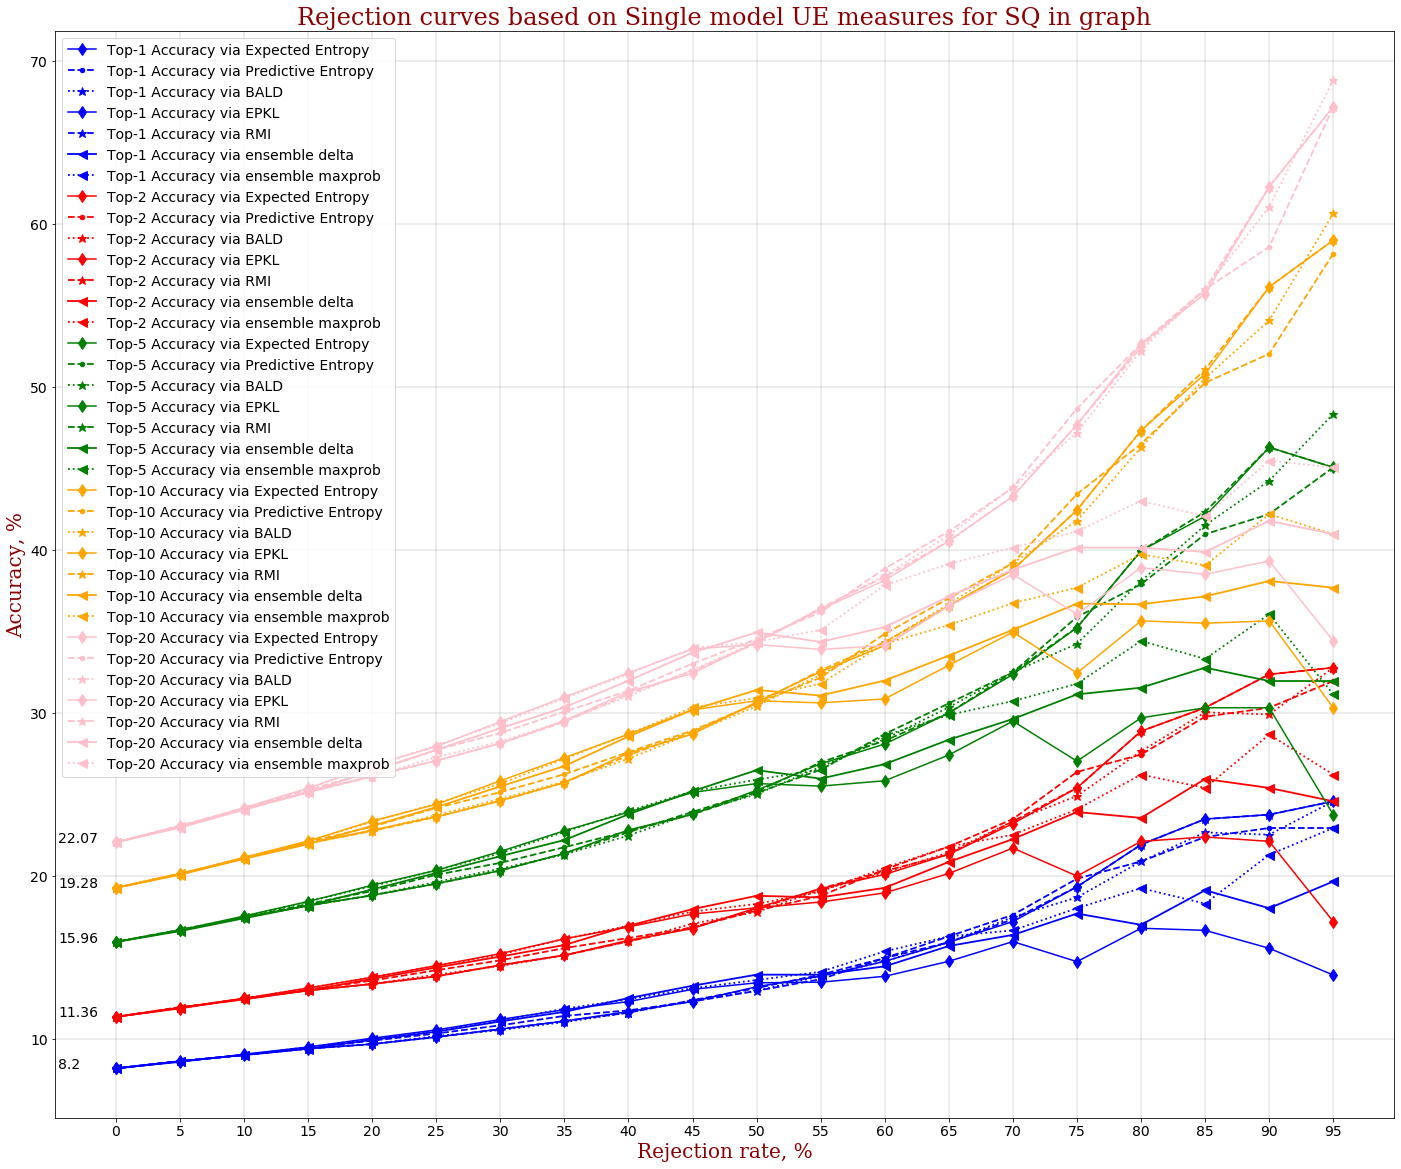

In [117]:
main_data_uncertainty, result_table = total_experiment_uncertainty_mc_dropout(

    data = sq_test,
    answers = sq_test_answers,
    data_name = "SQ in graph",
    output_file_name = "SQ_In_GRAPH_MC_DROPOUT_BS20",
    model = t5_qa_model,
    tokenizer = t5_tok,
    model_type = "T5_XL_SSM_NQ_model",
    num_quantiles = 20,
    seed = 42,
    ensemble_size = 5,
    num_beams = 20,
    need_report = False,
    plot_rejection_curves = True,
    top_ks = [1, 2, 5, 10, 20],
    top_k_to_plot = [1,2,5,10, 20],
    
    
)

In [118]:
result_table

Model Beam Size        UE SQ in graph                                 \
                              top-1 acc top-2 acc top-5 acc top-10 acc   
0   EoP        20     score      0.1394    0.1881    0.2561     0.3058   
1   EoP        20     delta      0.1349    0.1831    0.2488     0.2956   
2   EoP        20  eentropy      0.1276    0.1737    0.2406     0.2882   
3   EoP        20  pentropy      0.1426    0.1930    0.2693     0.3281   
4   EoP        20      bald      0.1415    0.1916    0.2696     0.3274   
5   EoP        20      epkl      0.1434    0.1938    0.2715     0.3289   
6   EoP        20       rmi      0.1436    0.1939    0.2718     0.3292   

              
  top-20 acc  
0     0.3400  
1     0.3293  
2     0.3225  
3     0.3712  
4     0.3701  
5     0.3699  
6     0.3700

## RuBQ 1hop bs 20

In [7]:
######################### <- HERE DETERMINE DATA 

########## load data

rubq_test = np.load("all_EN_rubq_test_questions_1_hop_uri.npy")
rubq_answers = np.load("all_rubq_test_answers_1_hop_uri.npy", allow_pickle=True)
entities_test_rubq = np.load("entities_test_rubq.npy")
rubq_test_answers = np.load("all_rubq_test_answers_1_hop_uri.npy", allow_pickle=True)
rubq_test = pd.DataFrame({"subject":entities_test_rubq, "question":rubq_test})

sample_questions = len(list(rubq_test.question))
questions = list(rubq_test.question)[:sample_questions]

########################## parameters <- HERE DEFINE PARAMS
name_of_dataset = "RUBQ2_1hop_test"
num_quantiles = 20
num_beams = 20
answers = list(rubq_test_answers)
top_ks = [1, 2, 5, 10, 20]
model_type = "t5-xl-ssm-nq"
source = "SINGLE_MODEL_RUBQ2_1HOP_TEST_BS20"



main_data_uncertainty, result_table = total_experiment_uncertainty_mc_dropout(

    data = questions,
    answers = answers,
    data_name = "RUBQ2_1HOP_test",
    output_file_name = "RUBQ2_1HOP_TEST_DROPOUT_BS_20",
    model = t5_qa_model,
    tokenizer = t5_tok,
    model_type = "T5_XL_SSM_NQ_model",
    num_quantiles = 20,
    seed = 42,
    ensemble_size = 5,
    num_beams = 20,
    need_report = False,
    plot_rejection_curves = True,
    top_ks = [1, 2, 5, 10, 20],
    top_k_to_plot = [1,2,5,10, 20],
    
    
)

  0%|          | 1/1186 [00:01<35:21,  1.79s/it]


RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 3; 23.70 GiB total capacity; 10.92 GiB already allocated; 3.56 MiB free; 10.96 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

# SQ full test bs 20

In [121]:

sq_test = list(np.load("simple_questions_test.npy")[:200,3])
sq_test_answers = np.array([[el] for el in list(np.load("simple_questions_test.npy")[:200,2])])



In [122]:
main_data_uncertainty, result_table = total_experiment_uncertainty_mc_dropout(

    data = sq_test,
    answers = sq_test_answers,
    data_name = "SQ full test",
    output_file_name = "SQ_full_test_DROPOUT_BS20",
    model = t5_qa_model,
    tokenizer = t5_tok,
    model_type = "T5_XL_SSM_NQ_model",
    num_quantiles = 20,
    seed = 42,
    ensemble_size = 5,
    num_beams = 20,
    need_report = False,
    plot_rejection_curves = True,
    top_ks = [1, 2, 5, 10, 20],
    top_k_to_plot = [1,2,5,10, 20],
    
    
)

 10%|█         | 21/200 [00:17<02:29,  1.20it/s]


KeyboardInterrupt: 

# SQ full test bs 10

In [36]:

sq_test = list(np.load("simple_questions_test.npy")[:,3])
sq_test_answers = np.array([[el] for el in list(np.load("simple_questions_test.npy")[:,2])])



In [ ]:
main_data_uncertainty, result_table = total_experiment_uncertainty_mc_dropout(

    data = sq_test,
    answers = sq_test_answers,
    data_name = "SQ full test",
    output_file_name = "SQ_FULL_TEST_DROPOUT_BS10",
    model = model,
    tokenizer = tokenizer,
    dropout_rate = 0.01,
    model_type = "T5_XL_SSM_NQ_model",
    num_quantiles = 20,
    seed = 42,
    ensemble_size = 5,
    num_beams = 10,
    need_report = False,
    plot_rejection_curves = True,
    top_ks = [1, 2, 5, 10],
    top_k_to_plot = [1, 2, 5, 10], 
    force_replace_zeros = False,
    max_sequence_length = 5
)

  3%|▎         | 160/4751 [02:01<58:33,  1.31it/s]  

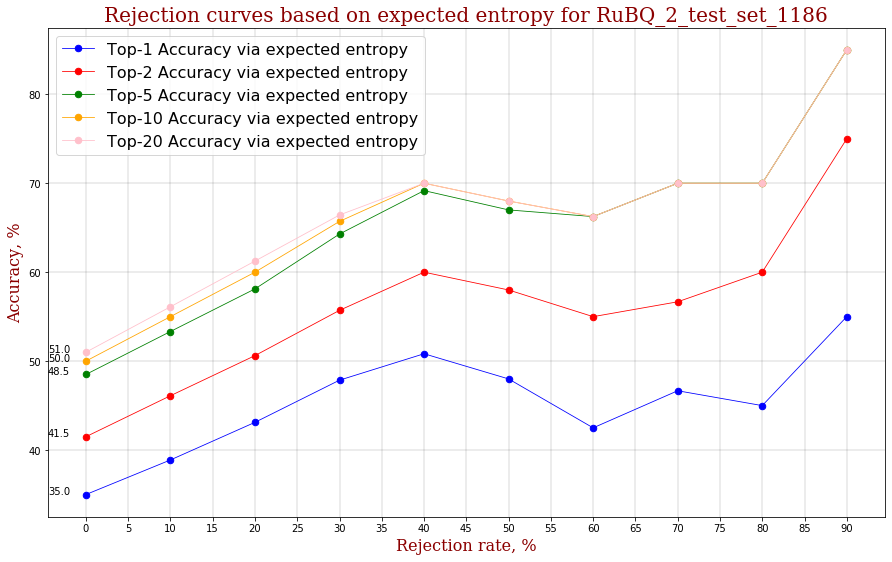

In [63]:
accuracy_for_each_topk_eentropy, ue_metrics = UE_ensemble(
                                                ensemble_metric_name = "expected entropy",
                                                answers = rubq_test_answers,
                                                dataset_name = "RuBQ_2_test_set_1186",
                                                plot_rejection_curves = True,
                                                predictions = res,
                                                num_quantiles = num_quantiles,
                                                ensemble_deltas = ensemble_deltas,
                                                ensemble_max_probs = ensemble_max_probs,
                                                eentropies = eentropies,
                                                pentropies = pentropies,
                                                balds = balds,
                                                epkls = epkls,
                                                rmis = rmis,
                                                top_ks = [1, 2, 5, 10, 20],
                                                model_type = "T5_XL_SSM_NQ_model",
                                                need_report = False)

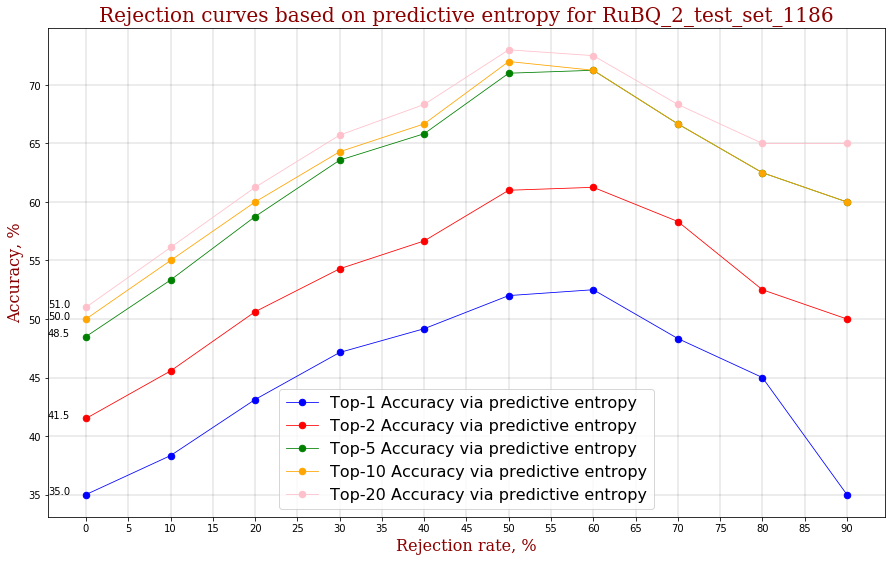

In [64]:
accuracy_for_each_topk_pentropy, ue_metrics = UE_ensemble(
                                                ensemble_metric_name = "predictive entropy",
                                                answers = rubq_test_answers,
                                                dataset_name = "RuBQ_2_test_set_1186",
                                                plot_rejection_curves = True,
                                                predictions = res,
                                                num_quantiles = num_quantiles,
                                                ensemble_deltas = None,
                                                ensemble_max_probs = None,
                                                eentropies = eentropies,
                                                pentropies = pentropies,
                                                balds = None,
                                                epkls = None,
                                                rmis = None,
                                                top_ks = [1, 2, 5, 10, 20],
                                                model_type = "T5_XL_SSM_NQ_model",
                                                need_report = False)

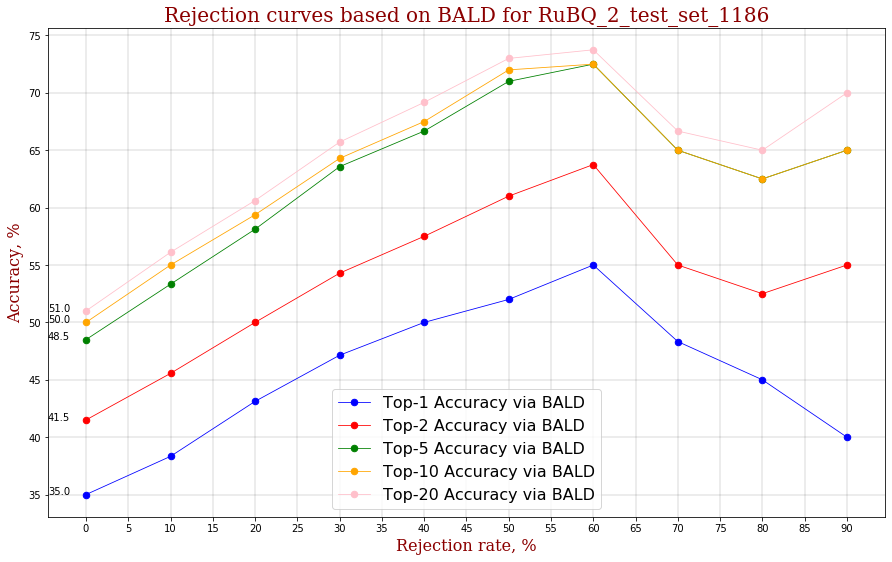

In [65]:
accuracy_for_each_topk_bald, ue_metrics = UE_ensemble(
                                                ensemble_metric_name = "BALD",
                                                answers = rubq_test_answers,
                                                dataset_name = "RuBQ_2_test_set_1186",
                                                plot_rejection_curves = True,
                                                predictions = res,
                                                num_quantiles = num_quantiles,
                                                ensemble_deltas = None,
                                                ensemble_max_probs = None,
                                                eentropies = eentropies,
                                                pentropies = pentropies,
                                                balds = balds,
                                                epkls = None,
                                                rmis = None,
                                                top_ks = [1, 2, 5, 10, 20],
                                                model_type = "T5_XL_SSM_NQ_model",
                                                need_report = False)

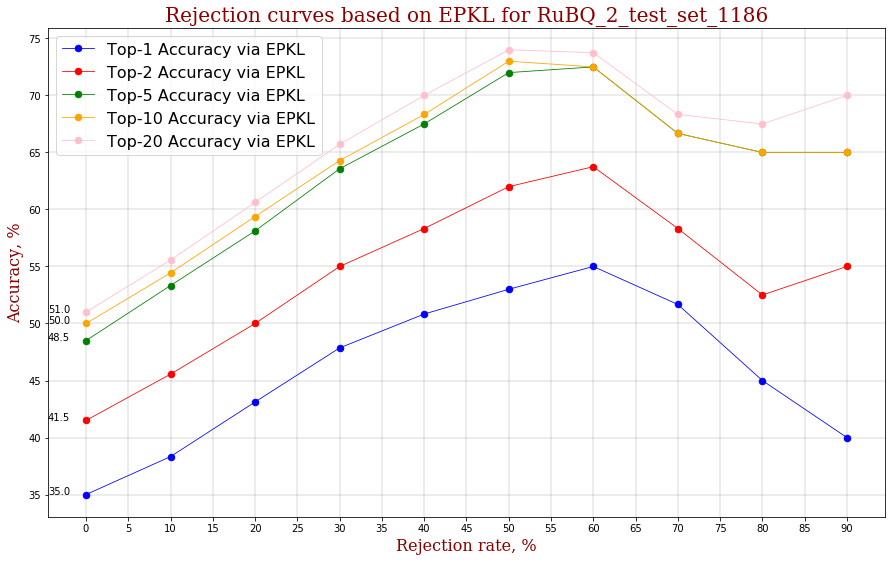

In [66]:
accuracy_for_each_topk_epkl, ue_metrics = UE_ensemble(
                                                ensemble_metric_name = "EPKL",
                                                answers = rubq_test_answers,
                                                dataset_name = "RuBQ_2_test_set_1186",
                                                plot_rejection_curves = True,
                                                predictions = res,
                                                num_quantiles = num_quantiles,
                                                ensemble_deltas = None,
                                                ensemble_max_probs = None,
                                                eentropies = eentropies,
                                                pentropies = pentropies,
                                                balds = balds,
                                                epkls = epkls,
                                                rmis = None,
                                                top_ks = [1, 2, 5, 10, 20],
                                                model_type = "T5_XL_SSM_NQ_model",
                                                need_report = False)

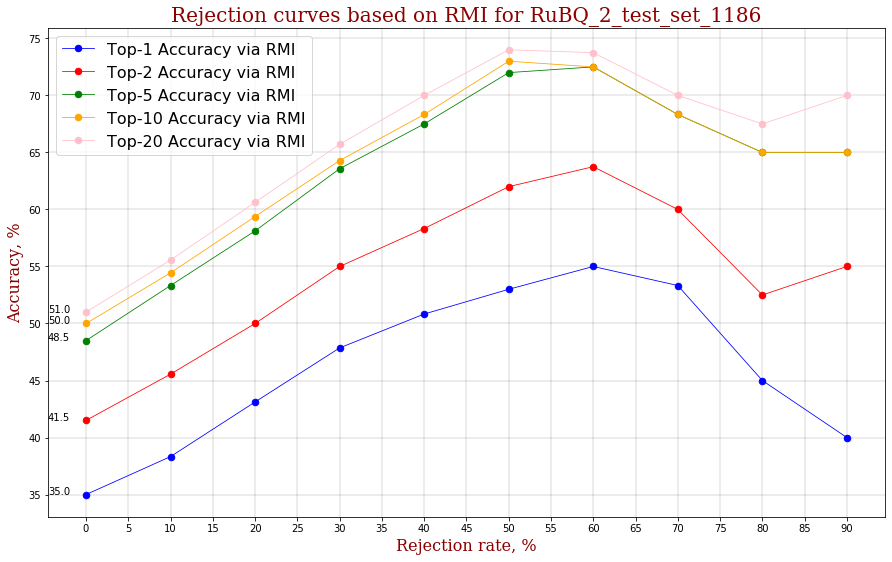

In [67]:
accuracy_for_each_topk_rmi, ue_metrics = UE_ensemble(
                                                ensemble_metric_name = "RMI",
                                                answers = rubq_test_answers,
                                                dataset_name = "RuBQ_2_test_set_1186",
                                                plot_rejection_curves = True,
                                                predictions = res,
                                                num_quantiles = num_quantiles,
                                                ensemble_deltas = None,
                                                ensemble_max_probs = None,
                                                eentropies = eentropies,
                                                pentropies = pentropies,
                                                balds = balds,
                                                epkls = epkls,
                                                rmis = rmis,
                                                top_ks = [1, 2, 5, 10, 20],
                                                model_type = "T5_XL_SSM_NQ_model",
                                                need_report = False)

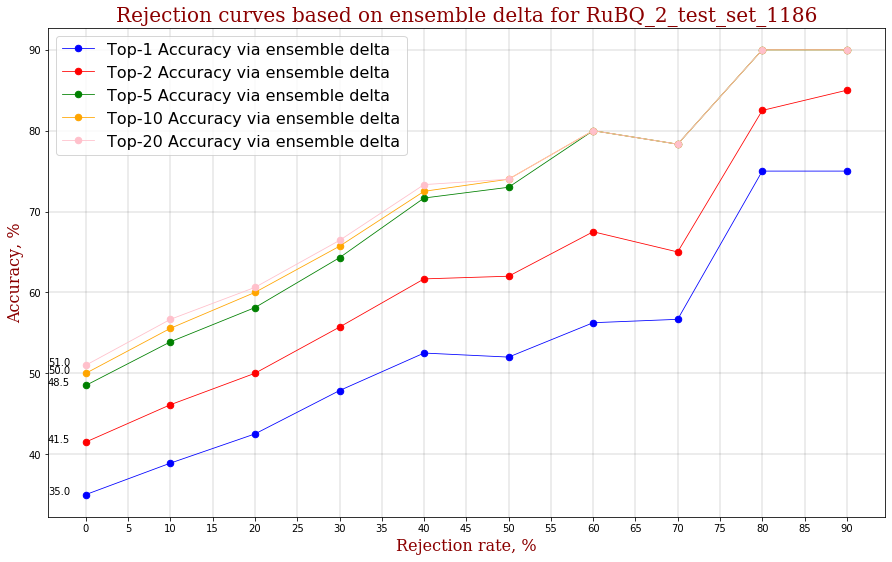

In [68]:
accuracy_for_each_topk_ensemble_delta, ue_metrics = UE_ensemble(
                                                ensemble_metric_name = "ensemble delta",
                                                answers = rubq_test_answers,
                                                dataset_name = "RuBQ_2_test_set_1186",
                                                plot_rejection_curves = True,
                                                predictions = res,
                                                num_quantiles = num_quantiles,
                                                ensemble_deltas = ensemble_deltas,
                                                ensemble_max_probs = ensemble_max_probs,
                                                eentropies = eentropies,
                                                pentropies = pentropies,
                                                balds = balds,
                                                epkls = epkls,
                                                rmis = rmis,
                                                top_ks = [1, 2, 5, 10, 20],
                                                model_type = "T5_XL_SSM_NQ_model",
                                                need_report = False)

len(list_of_predictions) 20 

top_k_list_of_predictions [['Electric guitar'], ['The Strait of'], ['Cambodia'], ['Tennis'], ['Florida'], ['The Plantagenet'], ['Albany'], ['The Netherlands'], ['Stamp collecting'], ['Tigris'], ['Ice hockey'], ['Atmosphe'], ['The Volga'], ['Amharic'], ['The city of Austin'], ['Baroque'], ['Central forward'], ['Peru'], ['The United States'], ['The Colorado River']] 

top_k_list_of_predicted_ids [['Q78987'], ['None'], ['Q424'], ['Q847'], ['Q812'], ['Q106151'], ['Q137573'], ['Q55'], ['Q856075'], ['Q35591'], ['Q41466'], ['None'], ['Q626'], ['Q28244'], ['None'], ['Q37853'], ['Q280658'], ['Q419'], ['Q30'], ['Q1265']]
accuracy 50.0 

Top-1 accuracy on the 10% the most confident from the entropy point of view = 50.0% 

len(list_of_predictions) 40 

top_k_list_of_predictions [['William Shakespeare'], ['Electric guitar'], ['Spain'], ['The Mercalli'], ['Football'], ['The Strait of'], ['Cambodia'], ['Nepal'], ['Arizona'], ['Tennis'], ['Florida'], ['The Plantagenet'], 

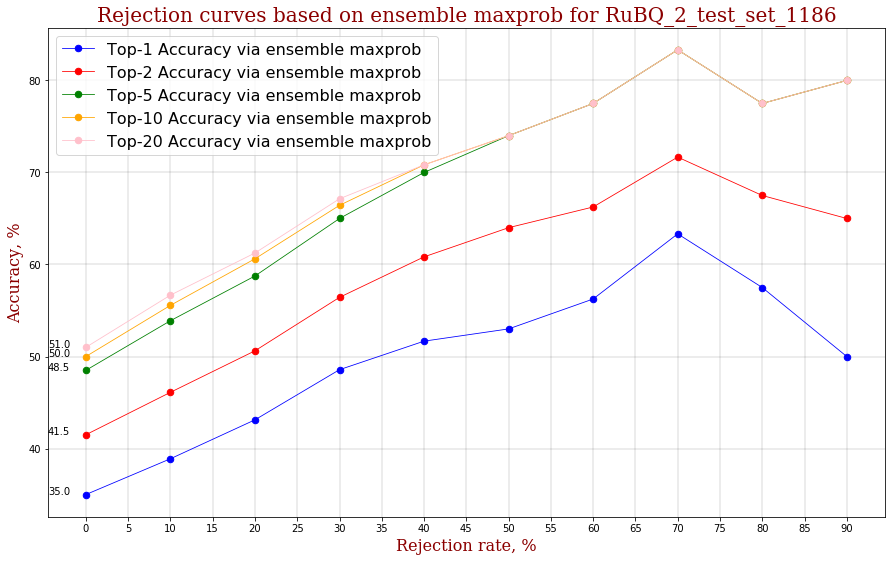

In [69]:
accuracy_for_each_topk_ensemble_maxprob, ue_metrics = UE_ensemble(
                                                ensemble_metric_name = "ensemble maxprob",
                                                answers = rubq_test_answers,
                                                dataset_name = "RuBQ_2_test_set_1186",
                                                plot_rejection_curves = True,
                                                predictions = res,
                                                num_quantiles = num_quantiles,
                                                ensemble_deltas = ensemble_deltas,
                                                ensemble_max_probs = ensemble_max_probs,
                                                eentropies = eentropies,
                                                pentropies = pentropies,
                                                balds = balds,
                                                epkls = epkls,
                                                rmis = rmis,
                                                top_ks = [1, 2, 5, 10, 20],
                                                model_type = "T5_XL_SSM_NQ_model",
                                                need_report = True)

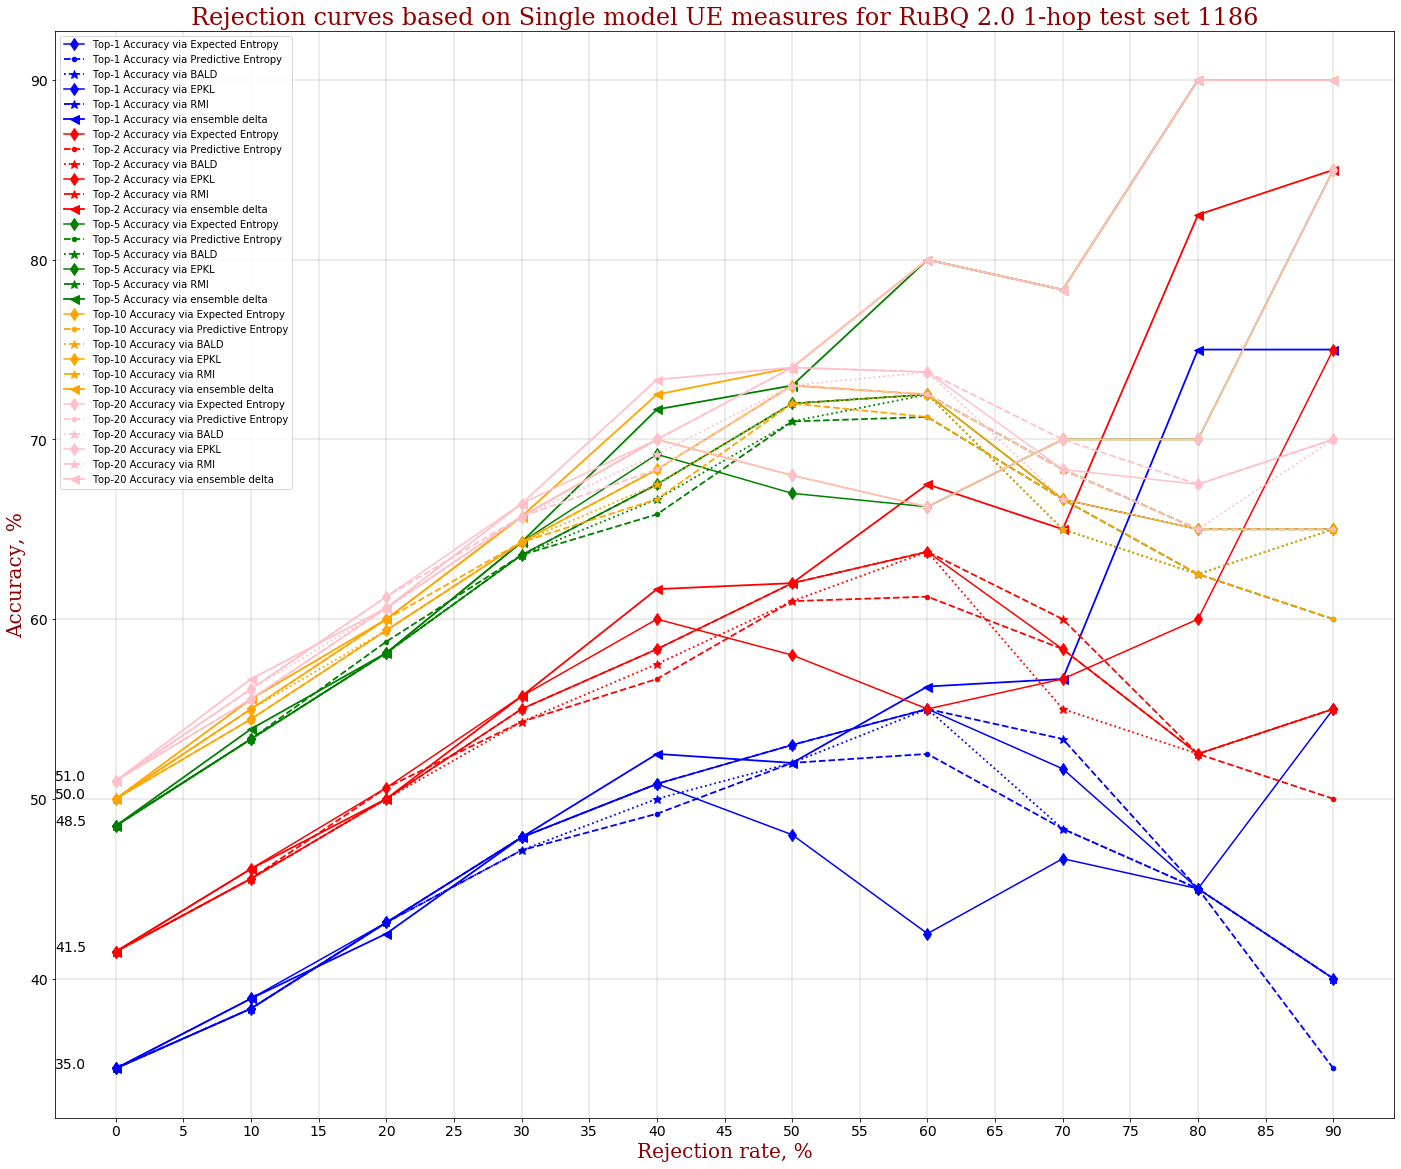

In [75]:
aggregation_plot_ensemble_measures(
    ue_metrics_to_plot = ["expected entropy", "predictive entropy", "BALD", "EPKL", "RMI", "ensemble delta"],
    top_k_to_plot = [1,2,5,10,20],
    name_of_dataset = "RuBQ 2.0 1-hop test set 1186",
    accuracy_for_each_topk_ensemble_maxprob = accuracy_for_each_topk_ensemble_maxprob,
    accuracy_for_each_topk_ensemble_delta = accuracy_for_each_topk_ensemble_delta,
    accuracy_for_each_topk_eentropy = accuracy_for_each_topk_eentropy,
    accuracy_for_each_topk_pentropy = accuracy_for_each_topk_pentropy,
    accuracy_for_each_topk_bald = accuracy_for_each_topk_bald,
    accuracy_for_each_topk_epkl = accuracy_for_each_topk_epkl,
    accuracy_for_each_topk_rmi = accuracy_for_each_topk_rmi
)

# save data

In [24]:
single_model_result_sq_in_qraph = {
    "dredictive_distribution":result,    
    "predictions":predictions,
    "probabilities":probas,
    
   
    "entropies":entropies,
    "max_probs":maxprobs,
    "deltas":deltas,

    
    "accuracy_for_each_topk_entropy":res_entropy,
    "accuracy_for_each_topk_maxprob":res_maxprob,
    "accuracy_for_each_topk_delta":res_delta,
    
    "num_quantiles":num_quantiles,
    "top_ks":top_ks,
    "dataset_name":name_of_dataset,
    "num_beams":num_beams,
    "model":model_type,
    "name_of_dataset":name_of_dataset
}

# with open('single_model_result_sq_in_qraph_bs_20.pickle', 'wb') as handle:
#     pickle.dump(single_model_result_sq_in_qraph, handle, protocol=pickle.HIGHEST_PROTOCOL)




# with open("rubq_full_test_1809_single_model_UE.pickle", "rb") as f:
#     rubq_full_test_1809_single_model_UE = pickle.load(f)

NameError: name 'result' is not defined